In [1]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# Add src directory to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import the aggregation function from utils script
from src.utils import aggregate_interview_sequences

from src.data_loader import load_androids_corpus
from src.foundation_model_extractor import extract_wav2vec2_sequences

In [2]:
# Extract and Prepare All Sequence Data for DL Models
# Load metadata and extract clip-level sequences
BASE_DATA_PATH = 'E:/Dissertation_Data/Androids-Corpus' # Verify this path
print("Loading corpus metadata...")
reading_df, interview_df = load_androids_corpus(BASE_DATA_PATH, verbose=False)
participant_metadata = reading_df[['unique_participant_id', 'label', 'fold']].drop_duplicates().reset_index(drop=True)

SEQUENCES_READING_PATH = '../data/Processed_Features/features_wav2vec2_sequences_reading_task.pkl'
SEQUENCES_INTERVIEW_CLIPS_PATH = '../data/Processed_Features/features_wav2vec2_sequences_interview_clips.pkl'

# Run extraction for interview clips if the file doesn't already exist
if not os.path.exists(SEQUENCES_INTERVIEW_CLIPS_PATH):
    print("Extracting sequential embeddings for all interview clips...")
    interview_clip_sequences = extract_wav2vec2_sequences(interview_df)
    if interview_clip_sequences:
        print(f"Saving interview clip sequences to: {SEQUENCES_INTERVIEW_CLIPS_PATH}")
        with open(SEQUENCES_INTERVIEW_CLIPS_PATH, 'wb') as f: pickle.dump(interview_clip_sequences, f)
else:
    print(f"Interview clip sequences already exist. Loading from file.")

# Load all necessary sequence data
with open(SEQUENCES_READING_PATH, 'rb') as f: reading_sequences = pickle.load(f)
with open(SEQUENCES_INTERVIEW_CLIPS_PATH, 'rb') as f: interview_clip_sequences = pickle.load(f)
print(f"\nLoaded {len(reading_sequences)} Reading sequences and {len(interview_clip_sequences)} Interview clip sequences.")

# Aggregate interview clips into session-level sequences using the util function
interview_session_sequences = aggregate_interview_sequences(interview_clip_sequences, interview_df)
print(f"Aggregated clips for {len(interview_session_sequences)} participants.")

# Create the final Reading, Interview, and Combined datasets
# Remap reading sequences to be keyed by participant ID for consistency
reading_participant_map = reading_df.set_index('filename')['unique_participant_id']
reading_session_sequences = {reading_participant_map[fname]: seq for fname, seq in reading_sequences.items() if fname in reading_participant_map.index}

# Create combined sequences by concatenating reading and interview sequences
combined_session_sequences = {}
for participant_id in tqdm(participant_metadata['unique_participant_id'], desc="Creating Combined Sequences"):
    reading_seq = reading_session_sequences.get(participant_id)
    interview_seq = interview_session_sequences.get(participant_id)
    if reading_seq is not None and interview_seq is not None:
        combined_session_sequences[participant_id] = np.vstack([reading_seq, interview_seq])

# Store all prepared sequence sets in a final dictionary
sequence_sets = {
    'reading': reading_session_sequences,
    'interview': interview_session_sequences,
    'combined': combined_session_sequences
}
print("\n--- All sequence datasets are now prepared and ready for training. ---")

Loading corpus metadata...
Successfully loaded 112 Read task and 116 Interview task fold assignments.
Interview clip sequences already exist. Loading from file.

Loaded 111 Reading sequences and 857 Interview clip sequences.

Aggregating interview clips into single sequences per participant...


Aggregating Sequences: 0it [00:00, ?it/s]

Aggregated clips for 114 participants.


Creating Combined Sequences:   0%|          | 0/111 [00:00<?, ?it/s]


--- All sequence datasets are now prepared and ready for training. ---


In [3]:
# Load or Extract Reading Task Sequences

# Define the path to the reading task sequences file
SEQUENCES_READING_PATH = '../data/Processed_Features/features_wav2vec2_sequences_reading_task.pkl'

# Check if the file exists before running extraction
if not os.path.exists(SEQUENCES_READING_PATH):
    print("Reading task sequences not found. Running extraction...")
    
    # Check if the reading_df DataFrame is loaded
    if 'reading_df' in locals():
        print("\nExtracting sequential embeddings for the Reading Task...")
        
        # Call the extractor function
        reading_sequences = extract_wav2vec2_sequences(reading_df)
        
        # Save the new sequences to the pickle file
        if reading_sequences:
            print(f"Saving new reading task sequences to: {SEQUENCES_READING_PATH}")
            with open(SEQUENCES_READING_PATH, 'wb') as f:
                pickle.dump(reading_sequences, f)
            print("Extraction and saving complete.")
    else:
        print("ERROR: 'reading_df' not found. Cannot run extraction.")
else:
    print(f"Reading task sequences already exist. Loading from file: {SEQUENCES_READING_PATH}")

# Load the data regardless of whether it was just created or already existed
try:
    with open(SEQUENCES_READING_PATH, 'rb') as f:
        reading_sequences = pickle.load(f)
    
    print(f"\nSuccessfully loaded data for {len(reading_sequences)} reading files.")
    
    # Final Verification
    first_filename = list(reading_sequences.keys())[0]
    first_sequence = reading_sequences[first_filename]
    print(f"Verified sequence shape for '{first_filename}': {first_sequence.shape}")

except FileNotFoundError:
    print(f"ERROR: Could not load reading sequences from {SEQUENCES_READING_PATH}")

Reading task sequences already exist. Loading from file: ../data/Processed_Features/features_wav2vec2_sequences_reading_task.pkl

Successfully loaded data for 111 reading files.
Verified sequence shape for '01_CF56_1.wav': (4378, 768)


In [4]:
# Run Tuned CNN-LSTM Experiments for All Data Types

# Import
from src.dl_cv_strategies import run_pytorch_nested_cv_with_optuna

# Dictionary to store the results of the tuned DL experiments
tuned_dl_results = {}

# Define experiment parameters
N_TRIALS = 25      # Number of hyperparameter sets to try in each outer fold
N_EPOCHS = 50      # Maximum number of epochs for the final model training in each fold
PATIENCE = 10      # Patience for early stopping
BATCH_SIZE = 8

# Loop through the three prepared sequence sets
for name, seq_dict in sequence_sets.items():
    experiment_name = f'wav2vec2_cnn_lstm_tuned_{name}'
    results_save_path = f'../data/Processed_Features/results_{experiment_name}.pkl'
    
    if not os.path.exists(results_save_path):
        print(f"\n--- Running experiment: {experiment_name.upper()} ---")
        
        # Filter metadata for participants in the current dataset
        current_participants = list(seq_dict.keys())
        current_metadata_df = participant_metadata[participant_metadata['unique_participant_id'].isin(current_participants)]
        
        # Capture the new 'weights' output
        tuned_results_df, tuned_predictions, tuned_weights = run_pytorch_nested_cv_with_optuna(
            sequences_dict=seq_dict,
            metadata_df=current_metadata_df,
            n_trials=N_TRIALS,
            epochs=N_EPOCHS,
            patience=PATIENCE,
            batch_size=BATCH_SIZE
        )
        
        # Save results, now including the weights
        results_to_save = {
            'results_df': tuned_results_df, 
            'predictions': tuned_predictions, 
            'weights': tuned_weights # NEW
        }
        with open(results_save_path, 'wb') as f: pickle.dump(results_to_save, f)
        print(f"Results saved to {results_save_path}")
        all_results[experiment_name] = results_to_save
    else:
        print(f"\nLoading pre-computed results for {experiment_name.upper()}")
        with open(results_save_path, 'rb') as f:
            tuned_dl_results[experiment_name] = pickle.load(f)

print("\n--- All Tuned Deep Learning experiments are now complete. ---")


Loading pre-computed results for WAV2VEC2_CNN_LSTM_TUNED_READING

Loading pre-computed results for WAV2VEC2_CNN_LSTM_TUNED_INTERVIEW

Loading pre-computed results for WAV2VEC2_CNN_LSTM_TUNED_COMBINED

--- All Tuned Deep Learning experiments are now complete. ---


In [5]:
from sklearn.model_selection import StratifiedKFold
from src.dl_cv_strategies import SequenceDataset, collate_fn, _train_eval_loop
from torch.utils.data import DataLoader
import torch
from src.models import CNNLSTM
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Train and save the best Model for each data type with early stopping

from sklearn.model_selection import StratifiedKFold

# Dictionary to store loss histories for plotting
final_model_histories = {}

# Create a canonical metadata DataFrame with all participants to prevent KeyErrors
full_metadata = pd.concat([
    reading_df[['unique_participant_id', 'label']],
    interview_df[['unique_participant_id', 'label']]
]).drop_duplicates().reset_index(drop=True)

# Loop through each of the three core data types
for data_type in ['reading', 'interview', 'combined']:
    
    experiment_name = f'wav2vec2_cnn_lstm_tuned_{data_type}'
    MODEL_SAVE_PATH = f'../models/final_tuned_cnn_lstm_{data_type}.pt'
    
    if os.path.exists(MODEL_SAVE_PATH):
        print(f"Final model for '{data_type}' already exists. Loading history for plotting.")
        saved_data = torch.load(MODEL_SAVE_PATH, map_location=torch.device('cpu')) # Add map_location for safety
        if 'train_loss_history' in saved_data:
            final_model_histories[data_type] = {
                'train': saved_data['train_loss_history'],
                'val': saved_data['val_loss_history']
            }
        continue

    print(f"\n--- Preparing to train final model for: {data_type.upper()} ---")

    try:
        # Identify the best hyperparameters for this specific data type 
        # Check if the results for this data type exist before proceeding
        if experiment_name not in tuned_dl_results:
            print(f"Could not find tuned results for '{experiment_name}'. Skipping final model training.")
            continue
            
        results_df = tuned_dl_results[experiment_name]['results_df']
        best_fold_params = results_df.loc[results_df['f1_score'].idxmax()]['best_params']
        print(f"Found best hyperparameters for '{data_type}':\n{best_fold_params}")

        # Prepare the full dataset for final training
        full_sequences_dict = sequence_sets[data_type]
        participants_for_final_model = list(full_sequences_dict.keys())
        metadata_for_final_model = full_metadata[full_metadata['unique_participant_id'].isin(participants_for_final_model)]
        label_map_final = metadata_for_final_model.set_index('unique_participant_id')['label'].apply(lambda x: 1 if x == 'Patient' else 0)
        final_sequences = [full_sequences_dict[pid] for pid in participants_for_final_model]
        final_labels = label_map_final.loc[participants_for_final_model].values
        X_final, y_final = np.array(final_sequences, dtype=object), np.array(final_labels)

        # 80/20 train/validation split for early stopping
        final_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        final_train_idx, final_val_idx = next(final_splitter.split(X_final, y_final))
        X_train_final, X_val_final = X_final[final_train_idx], X_final[final_val_idx]
        y_train_final, y_val_final = y_final[final_train_idx], y_final[final_val_idx]
        final_train_dataset = SequenceDataset(X_train_final, y_train_final)
        final_val_dataset = SequenceDataset(X_val_final, y_val_final)
        final_train_loader = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
        final_val_loader = DataLoader(final_val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

        print(f"  > Final training set size: {len(X_train_final)}")
        print(f"  > Final validation set size: {len(X_val_final)}")

        # Build and train the final model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Separate model architecture params from training params
        model_params = {
            'dropout_rate': best_fold_params['dropout_rate'],
            'cnn_out_channels': best_fold_params['cnn_out_channels'],
            'lstm_hidden_dim': best_fold_params['lstm_hidden_dim'],
            'activation_fn': best_fold_params['activation_fn']
        }
        final_model = CNNLSTM(input_dim=final_sequences[0].shape[1], **model_params).to(device)
        
        optimizer = torch.optim.Adam(final_model.parameters(), lr=best_fold_params['learning_rate'])
        loss_fn = nn.CrossEntropyLoss()
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

        FINAL_TRAINING_EPOCHS = 100
        HIGH_PATIENCE = 25
        print(f"\nTraining final model for '{data_type}' for up to {FINAL_TRAINING_EPOCHS} epochs...")
        
        best_final_model, train_history, val_history = _train_eval_loop(
            final_model, final_train_loader, final_val_loader, loss_fn, 
            optimizer, scheduler, device, FINAL_TRAINING_EPOCHS, HIGH_PATIENCE
        )
        
        final_model_histories[data_type] = {'train': train_history, 'val': val_history}
        print("Final training complete.")

        # Save the final artefact
        os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)
        torch.save({
            'hyperparameters': best_fold_params,
            'model_state_dict': best_final_model.state_dict(),
            'train_loss_history': train_history,
            'val_loss_history': val_history
        }, MODEL_SAVE_PATH)
        print(f"Final model and histories for '{data_type}' saved to: {MODEL_SAVE_PATH}")

    except Exception as e:
        print(f"An error occurred during final model training for '{data_type}': {e}")

print("\n--- All final models have been trained and saved. ---")

Final model for 'reading' already exists. Loading history for plotting.
Final model for 'interview' already exists. Loading history for plotting.
Final model for 'combined' already exists. Loading history for plotting.

--- All final models have been trained and saved. ---


C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\1544089316.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(MODEL_SAVE_PATH, map_location=torch

--- Training/Validation Loss Curves for Final Models ---


C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\809815052.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_data = torch.load(MODEL_SAVE_PATH)


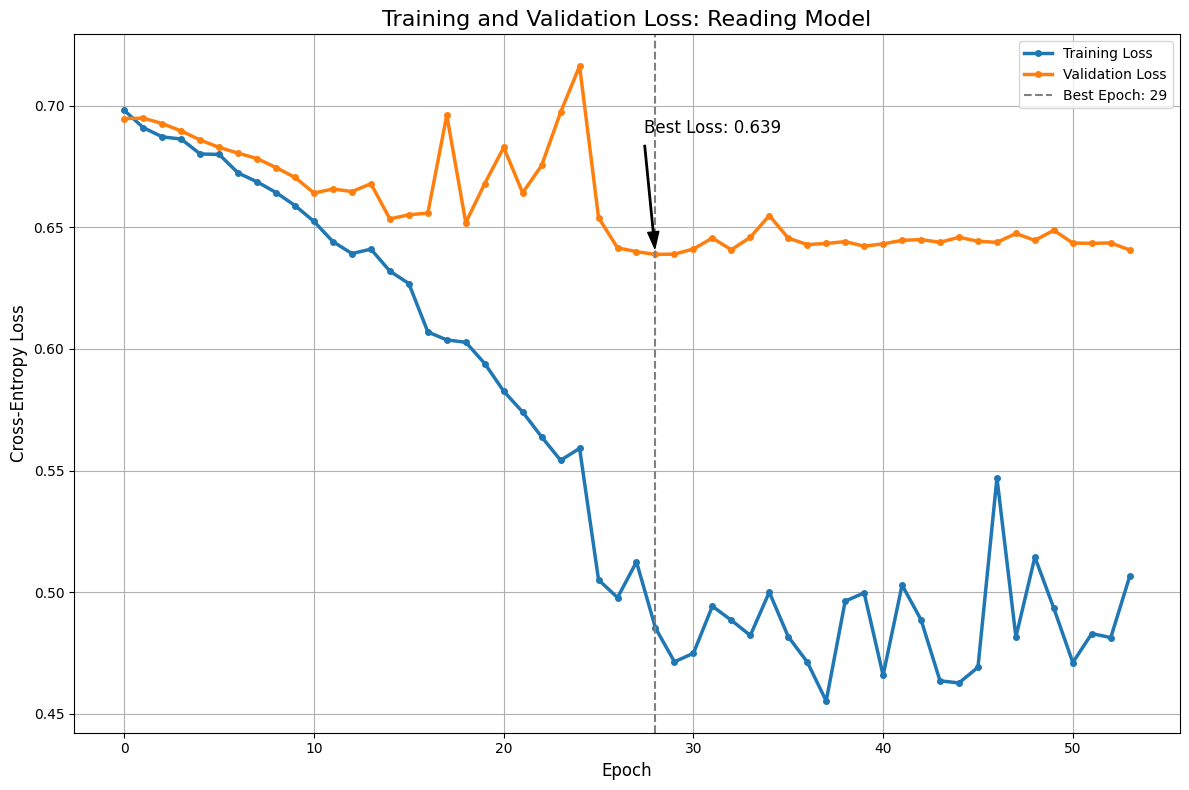

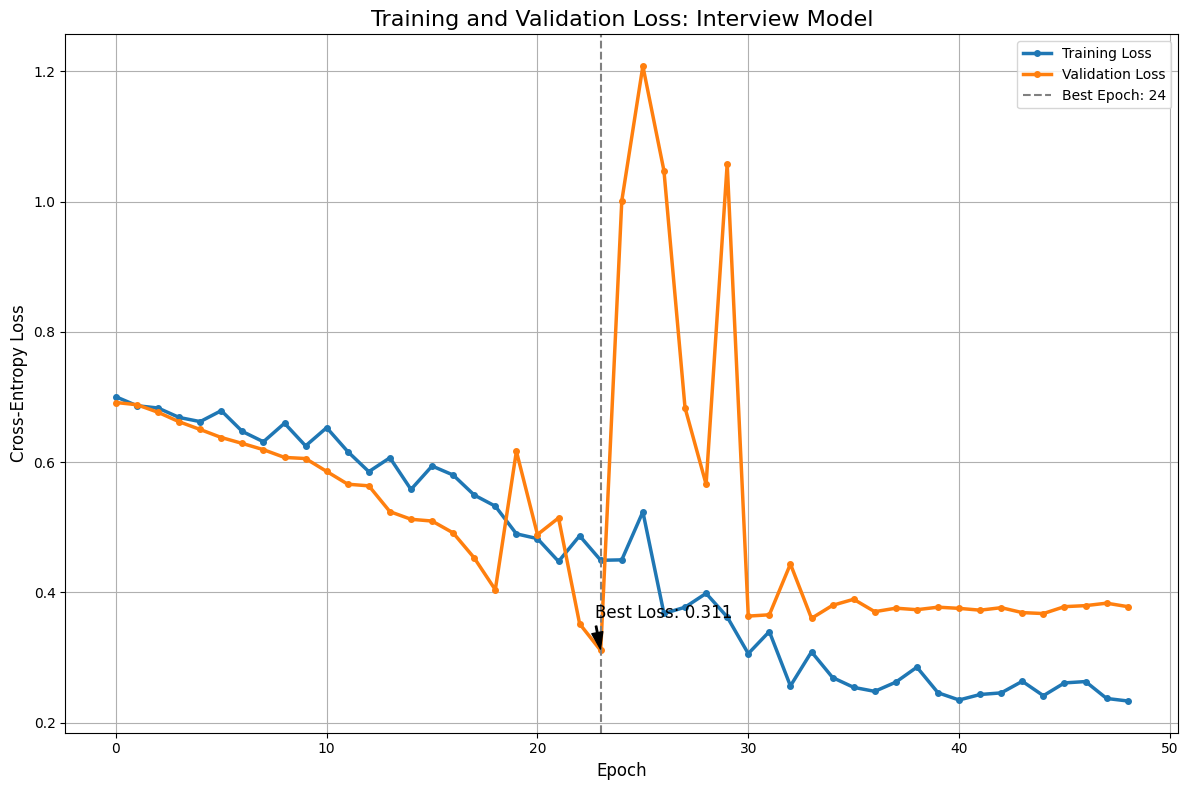

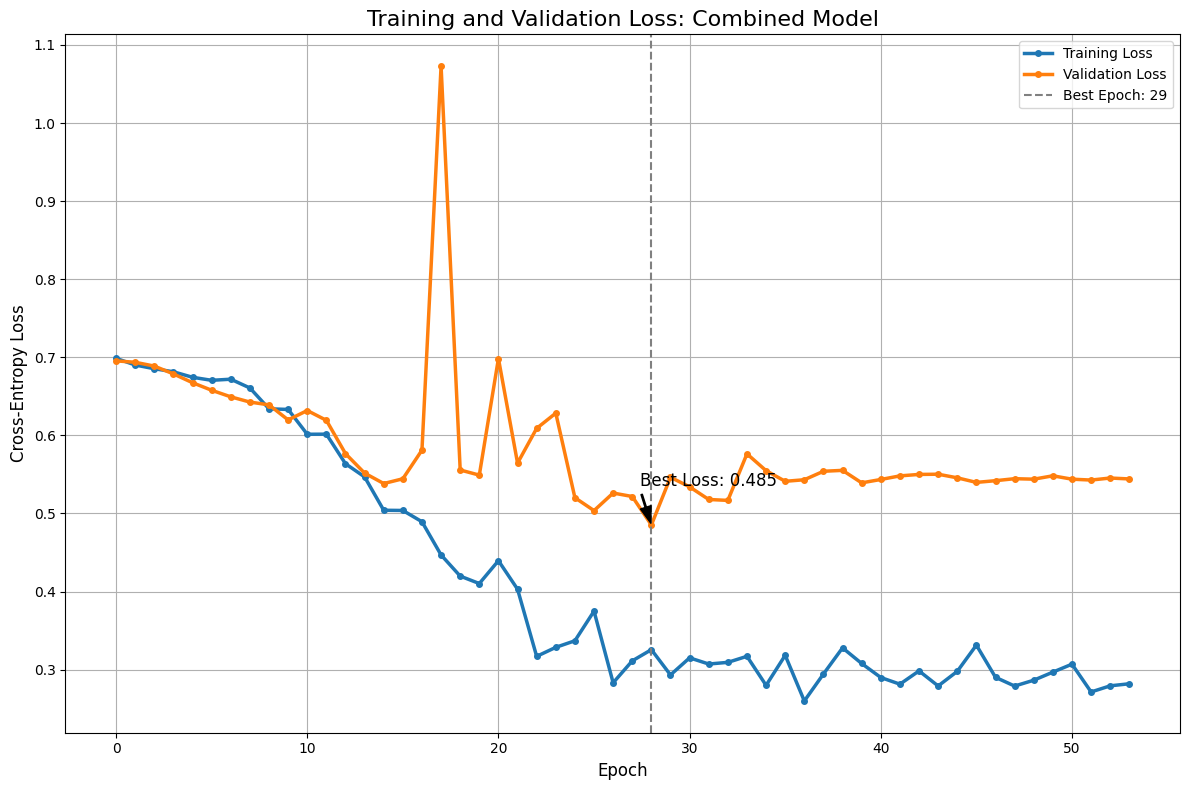

In [6]:
# Visualize Training and Validation Loss Curves

import matplotlib.pyplot as plt

print("--- Training/Validation Loss Curves for Final Models ---")

# Loop through the three data types to find their saved models and create a plot for each
for data_type in ['reading', 'interview', 'combined']:
    
    # Create a new, separate figure for each data type
    plt.figure(figsize=(12, 8))
    
    MODEL_SAVE_PATH = f'../models/final_tuned_cnn_lstm_{data_type}.pt'
    
    # Load the history directly from the saved model file
    if os.path.exists(MODEL_SAVE_PATH):
        saved_data = torch.load(MODEL_SAVE_PATH)
        
        # Check if the history was saved in the file
        if 'train_loss_history' in saved_data and 'val_loss_history' in saved_data:
            train_history = saved_data['train_loss_history']
            val_history = saved_data['val_loss_history']
            
            # Plot the training and validation loss
            plt.plot(train_history, label='Training Loss', color='C0', lw=2.5, marker='o', markersize=4)
            plt.plot(val_history, label='Validation Loss', color='C1', lw=2.5, marker='o', markersize=4)
            
            # Find the epoch with the best validation loss to annotate the plot
            best_epoch = np.argmin(val_history)
            best_val_loss = np.min(val_history)
            
            # Add a vertical line and annotation to mark the best epoch
            plt.axvline(x=best_epoch, color='grey', linestyle='--', label=f'Best Epoch: {best_epoch + 1}')
            plt.annotate(f'Best Loss: {best_val_loss:.3f}', 
                        xy=(best_epoch, best_val_loss), 
                        xytext=(best_epoch + 3, best_val_loss + 0.05), # Adjusted text position
                        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                        ha='center', fontsize=12)
            
            plt.title(f'Training and Validation Loss: {data_type.title()} Model', fontsize=16)
            plt.legend()
        else:
            plt.title(f'Model: {data_type.title()}\n(History not found in file)')
    else:
        plt.title(f'Model: {data_type.title()}\n(Model file not found)')

    # Add labels and grid, then show the plot
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Cross-Entropy Loss', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
# Load all experiment results into one dictionary

# Load the SVM results generated in notebook 03
SVM_RESULTS_PATH = '../data/Processed_Features/all_svm_results.pkl' 
if os.path.exists(SVM_RESULTS_PATH):
    with open(SVM_RESULTS_PATH, 'rb') as f:
        all_results = pickle.load(f)
else:
    print("Warning: SVM results file not found. Final comparison will only show DL models.")
    all_results = {}

# The 'tuned_dl_results' dictionary already exists in this notebook's memory
# from the previous cell. Add contents to master dictionary.
all_results.update(tuned_dl_results)

print(f"Successfully loaded a total of {len(all_results)} experiment results for final comparison.")

# Create and Display Summary Table
final_summary_data = []
for experiment_name, data in all_results.items():
    results_df = data['results_df']
    final_summary_data.append({
        'Experiment': experiment_name,
        'Mean F1-Score': results_df['f1_score'].mean(),
        'Std Dev F1-Score': results_df['f1_score'].std(),
        'Mean AUC': results_df['auc'].mean(),
        'Std Dev AUC': results_df['auc'].std(),
        'Mean Accuracy': results_df['accuracy'].mean(),
        'Std Dev Accuracy': results_df['accuracy'].std()
    })

final_summary_df = pd.DataFrame(final_summary_data).set_index('Experiment')

print("\n--- Results Table for Nested k-fold Cross Validation ---")
display(final_summary_df.style.background_gradient(cmap='viridis', subset=[c for c in final_summary_df.columns if 'Mean' in c], axis=0)
                          .background_gradient(cmap='viridis_r', subset=[c for c in final_summary_df.columns if 'Std Dev' in c], axis=0))

Successfully loaded a total of 21 experiment results for final comparison.

--- Results Table for Nested k-fold Cross Validation ---


,Mean F1-Score,Std Dev F1-Score,Mean AUC,Std Dev AUC,Mean Accuracy,Std Dev Accuracy
Experiment,,,,,,
mshds_reading_standard,0.734554,0.081263,0.810262,0.067562,0.738340,0.076011
mshds_reading_nested,0.706289,0.175999,0.764063,0.180749,0.711067,0.175819
opensmile_reading_standard,0.585608,0.104392,0.572300,0.096487,0.593676,0.099823
opensmile_reading_nested,0.563104,0.093535,0.565248,0.104721,0.566403,0.093311
wav2vec2_reading_standard,0.664464,0.070581,0.702631,0.095540,0.666403,0.070115
wav2vec2_reading_nested,0.654499,0.036262,0.765634,0.089987,0.657708,0.039486
mshds_interview_standard,0.718485,0.101461,0.769490,0.140613,0.724242,0.098427
mshds_interview_nested,0.708910,0.093763,0.766405,0.120753,0.714286,0.094658
opensmile_interview_standard,0.685432,0.039890,0.738333,0.039718,0.688312,0.035269


In [8]:
# Run Standard K-Fold Experiments for CNN-LSTM

from src.dl_cv_strategies import run_pytorch_standard_kfold_cv

# This dictionary will hold the best hyperparameters found from the nested CV runs
best_params_per_dataset = {}
for name in ['reading', 'interview', 'combined']:
    exp_name = f'wav2vec2_cnn_lstm_tuned_{name}'
    if exp_name in tuned_dl_results:
        results_df = tuned_dl_results[exp_name]['results_df']
        best_params = results_df.loc[results_df['f1_score'].idxmax()]['best_params']
        best_params_per_dataset[name] = best_params

# Loop through the three datasets and run the standard k-fold experiment
for name, seq_dict in sequence_sets.items():
    experiment_name = f'wav2vec2_cnn_lstm_standard_{name}'
    results_save_path = f'../data/Processed_Features/results_{experiment_name}.pkl'
    
    if name in best_params_per_dataset and not os.path.exists(results_save_path):
        print(f"\n--- Running STANDARD K-FOLD experiment: {experiment_name.upper()} ---")
        
        current_participants = list(seq_dict.keys())
        current_metadata_df = participant_metadata[participant_metadata['unique_participant_id'].isin(current_participants)]
        
        # Capture histories and weights
        results_df, predictions, histories, weights = run_pytorch_standard_kfold_cv(
            sequences_dict=seq_dict,
            metadata_df=current_metadata_df,
            hyperparams=best_params_per_dataset[name],
            epochs=100,
            patience=25,
            batch_size=BATCH_SIZE
        )
        
        # Save results, now including the histories and weights
        results_to_save = {
            'results_df': results_df, 
            'predictions': predictions, 
            'histories': histories, 
            'weights': weights
        }
        with open(results_save_path, 'wb') as f: pickle.dump(results_to_save, f)
        print(f"Results saved to {results_save_path}")
        all_results[experiment_name] = results_to_save
    else:
        print(f"\nSkipping or loading pre-computed results for {experiment_name.upper()}")
        if os.path.exists(results_save_path) and experiment_name not in all_results:
             with open(results_save_path, 'rb') as f: all_results[experiment_name] = pickle.load(f)

print("\n--- All Standard K-Fold DL experiments are complete. ---")


Skipping or loading pre-computed results for WAV2VEC2_CNN_LSTM_STANDARD_READING

Skipping or loading pre-computed results for WAV2VEC2_CNN_LSTM_STANDARD_INTERVIEW

Skipping or loading pre-computed results for WAV2VEC2_CNN_LSTM_STANDARD_COMBINED

--- All Standard K-Fold DL experiments are complete. ---


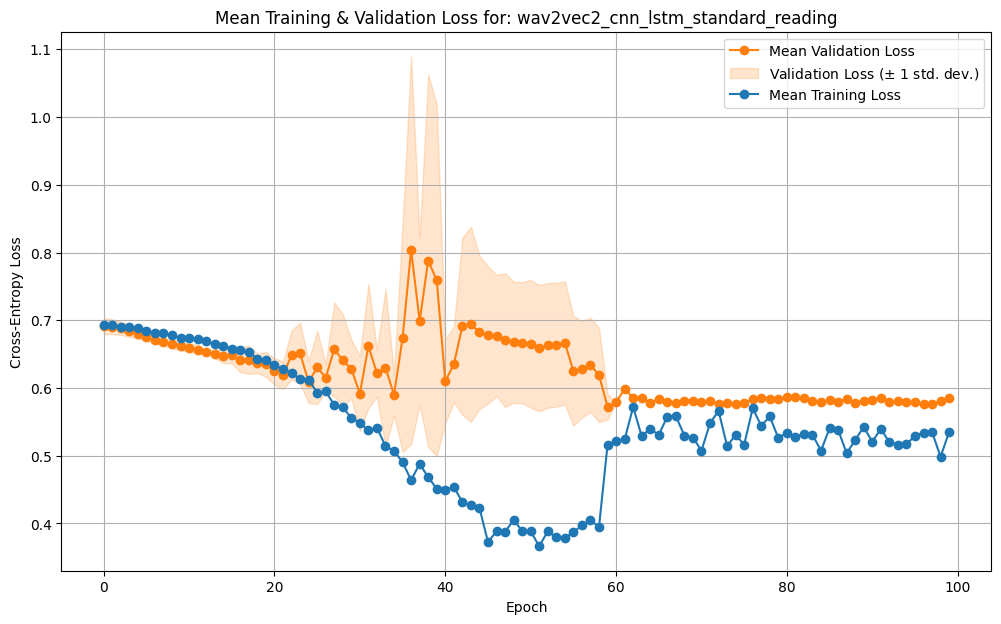

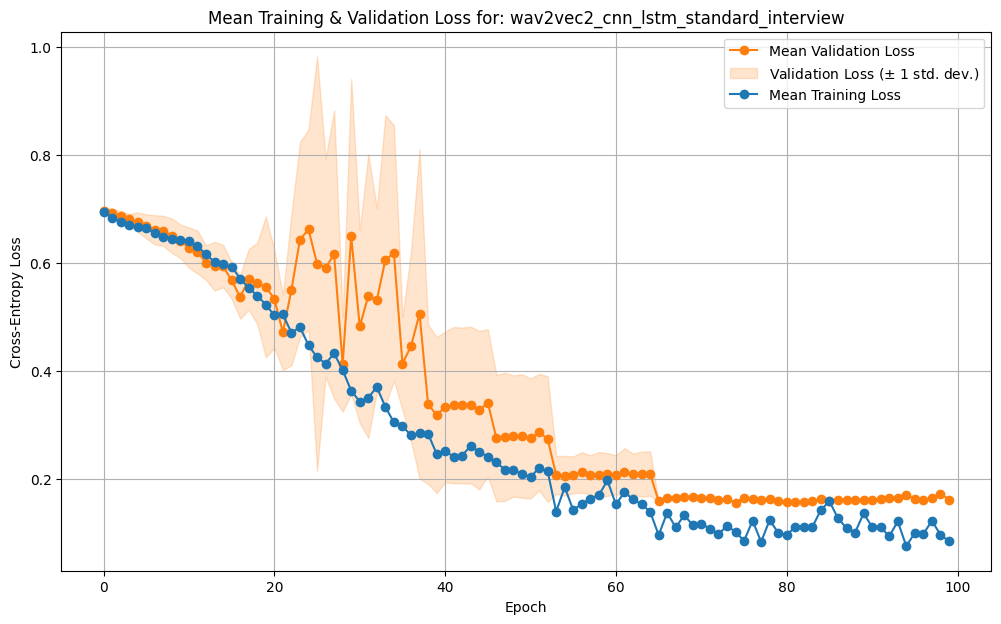

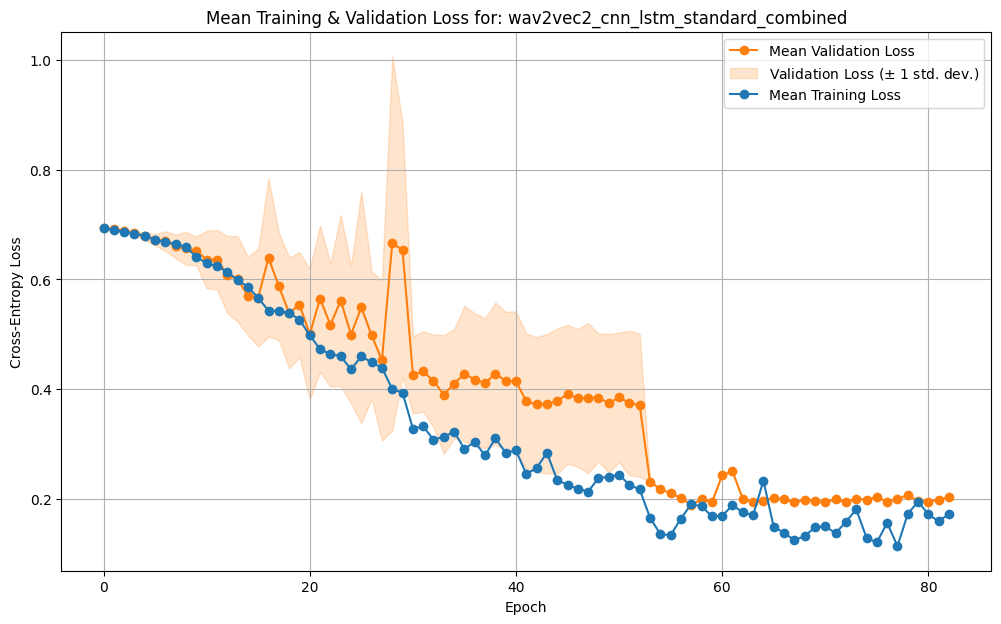

In [9]:
# Visualize Loss Curves for Standard K-Fold DL Experiments 

# This cell plots the mean and std dev of loss curves across the 5 folds for each experiment

for name in ['reading', 'interview', 'combined']:
    experiment_name = f'wav2vec2_cnn_lstm_standard_{name}'
    if experiment_name in all_results and 'histories' in all_results[experiment_name]:
        histories = all_results[experiment_name]['histories']
        
        plt.figure(figsize=(12, 7))
        
        # Process and plot for validation loss
        val_losses = [h['val'] for h in histories]
        # Pad shorter sequences with NaN to average correctly
        max_len = max(len(l) for l in val_losses)
        val_losses_padded = np.array([l + [np.nan]*(max_len - len(l)) for l in val_losses])
        
        mean_val_loss = np.nanmean(val_losses_padded, axis=0)
        std_val_loss = np.nanstd(val_losses_padded, axis=0)
        
        epochs = np.arange(len(mean_val_loss))
        
        plt.plot(epochs, mean_val_loss, 'o-', color='C1', label='Mean Validation Loss')
        plt.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss,
                         color='C1', alpha=0.2, label=r'Validation Loss ($\pm$ 1 std. dev.)')

        # Process and plot for training loss 
        train_losses = [h['train'] for h in histories]
        train_losses_padded = np.array([l + [np.nan]*(max_len - len(l)) for l in train_losses])
        mean_train_loss = np.nanmean(train_losses_padded, axis=0)
        plt.plot(epochs, mean_train_loss, 'o-', color='C0', label='Mean Training Loss')
        
        plt.title(f'Mean Training & Validation Loss for: {experiment_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-Entropy Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

In [10]:
# Summary Table for all CNN-LSTM Experiments

# Define the names of the 6 DL experiments
dl_experiment_names = [
    'wav2vec2_cnn_lstm_standard_reading',
    'wav2vec2_cnn_lstm_tuned_reading',
    'wav2vec2_cnn_lstm_standard_interview',
    'wav2vec2_cnn_lstm_tuned_interview',
    'wav2vec2_cnn_lstm_standard_combined',
    'wav2vec2_cnn_lstm_tuned_combined'
]

# Filter the main 'all_results' dictionary
dl_summary_data = []
for name in dl_experiment_names:
    if name in all_results:
        results_df = all_results[name]['results_df']
        dl_summary_data.append({
            'Experiment': name,
            'Mean F1-Score': results_df['f1_score'].mean(),
            'Std Dev F1-Score': results_df['f1_score'].std(),
            'Mean AUC': results_df['auc'].mean(),
            'Std Dev AUC': results_df['auc'].std(),
        })

dl_summary_df = pd.DataFrame(dl_summary_data).set_index('Experiment')

print("\n--- Final Performance Summary for All CNN-LSTM Experiments. ---")
display(dl_summary_df.style.background_gradient(cmap='viridis', subset=[c for c in dl_summary_df.columns if 'Mean' in c], axis=0)
                          .background_gradient(cmap='viridis_r', subset=[c for c in dl_summary_df.columns if 'Std Dev' in c], axis=0)
                          .format("{:.3f}"))


--- Final Performance Summary for All CNN-LSTM Experiments. ---


,Mean F1-Score,Std Dev F1-Score,Mean AUC,Std Dev AUC
Experiment,,,,
wav2vec2_cnn_lstm_standard_reading,0.629,0.134,0.741,0.096
wav2vec2_cnn_lstm_tuned_reading,0.700,0.099,0.779,0.052
wav2vec2_cnn_lstm_standard_interview,0.740,0.088,0.814,0.072
wav2vec2_cnn_lstm_tuned_interview,0.770,0.106,0.865,0.096
wav2vec2_cnn_lstm_standard_combined,0.607,0.157,0.777,0.090
wav2vec2_cnn_lstm_tuned_combined,0.779,0.086,0.847,0.093


--- Feature Importance Stability Plots for DL Models ---


C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\1012311418.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stability_df.head(20), x='count', y='feature_index', palette='cubehelix', orient='h')


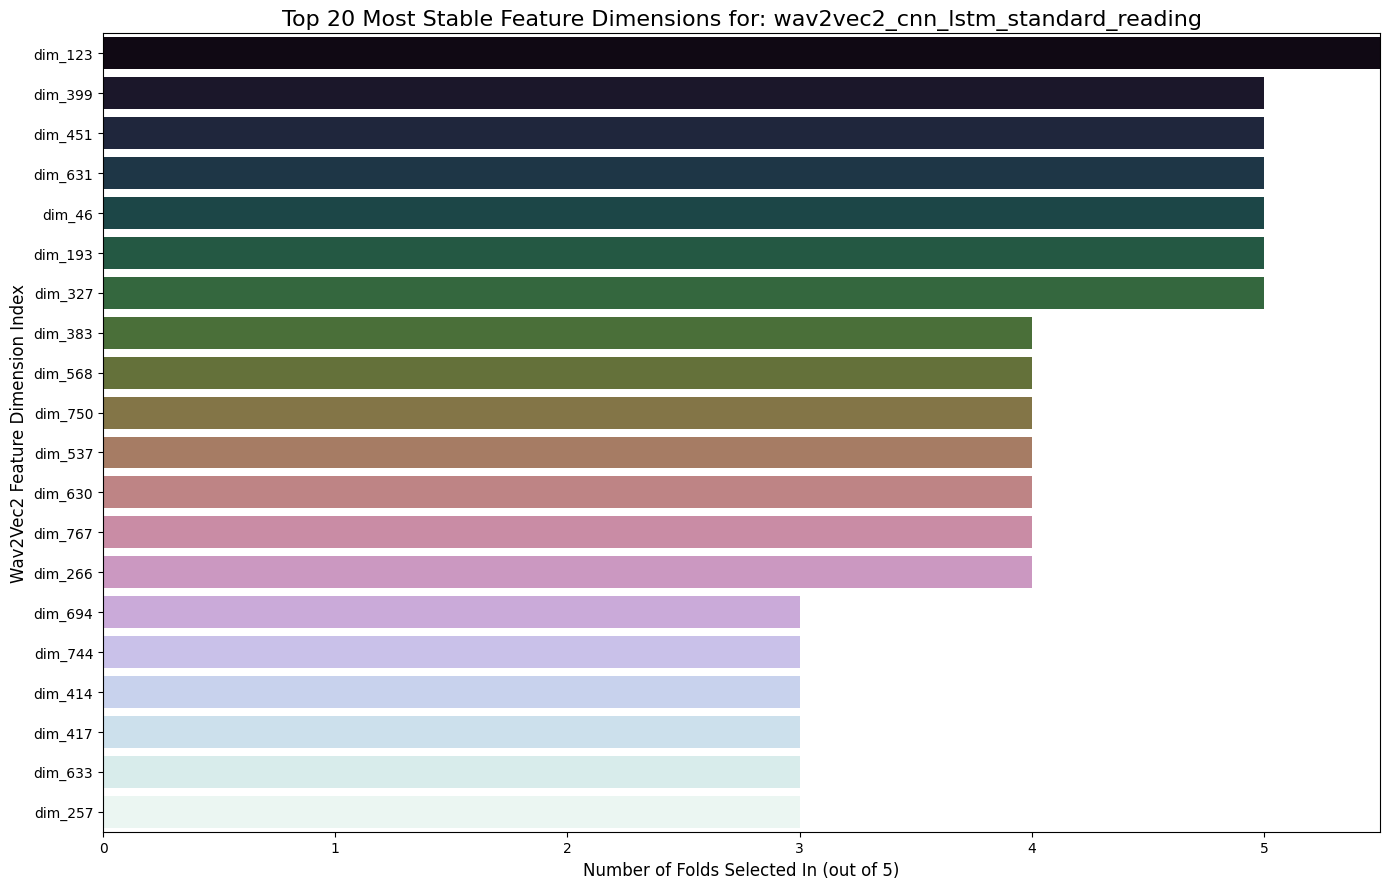

C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\1012311418.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stability_df.head(20), x='count', y='feature_index', palette='cubehelix', orient='h')


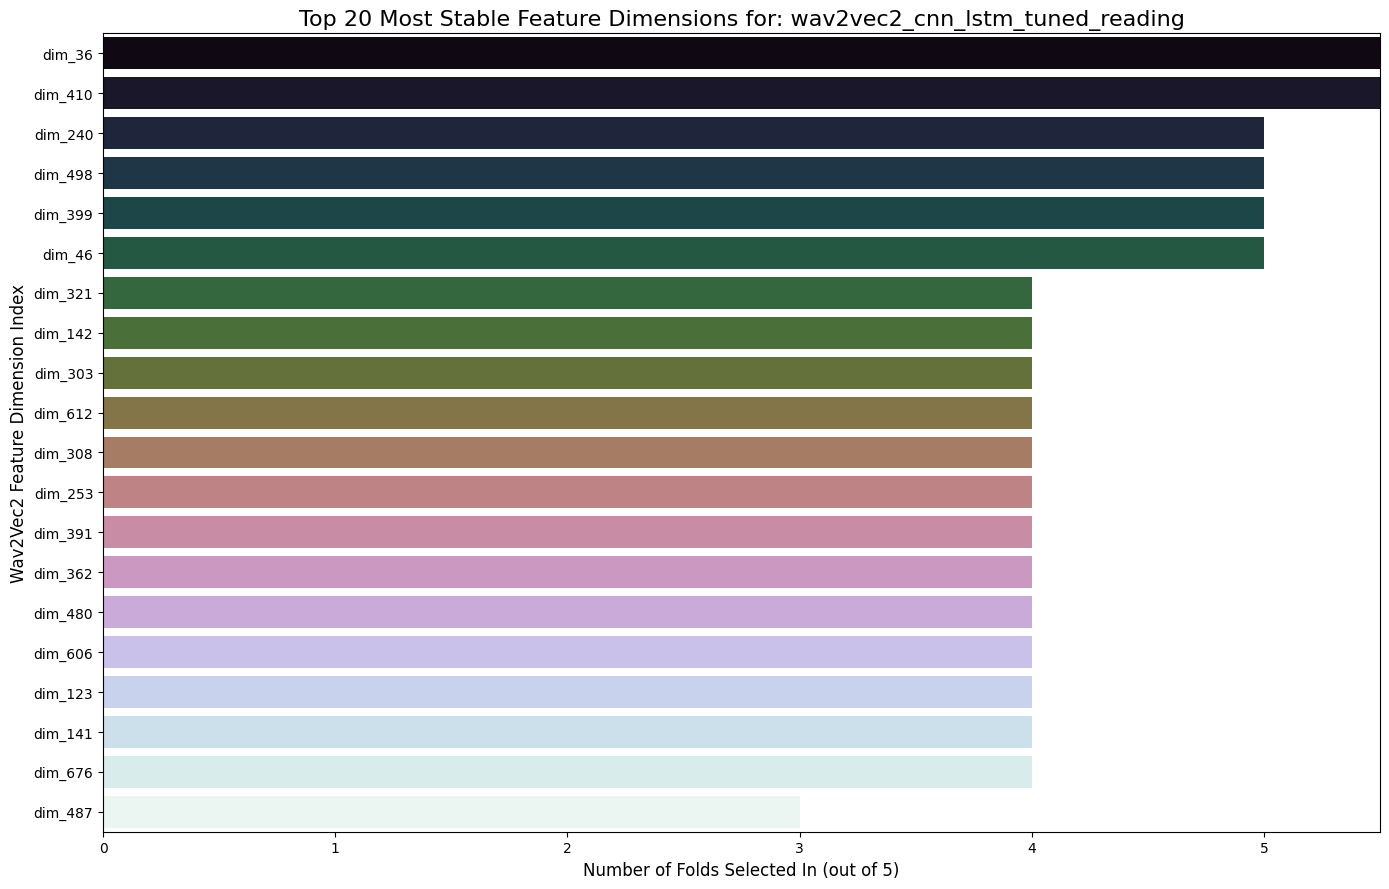

C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\1012311418.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stability_df.head(20), x='count', y='feature_index', palette='cubehelix', orient='h')


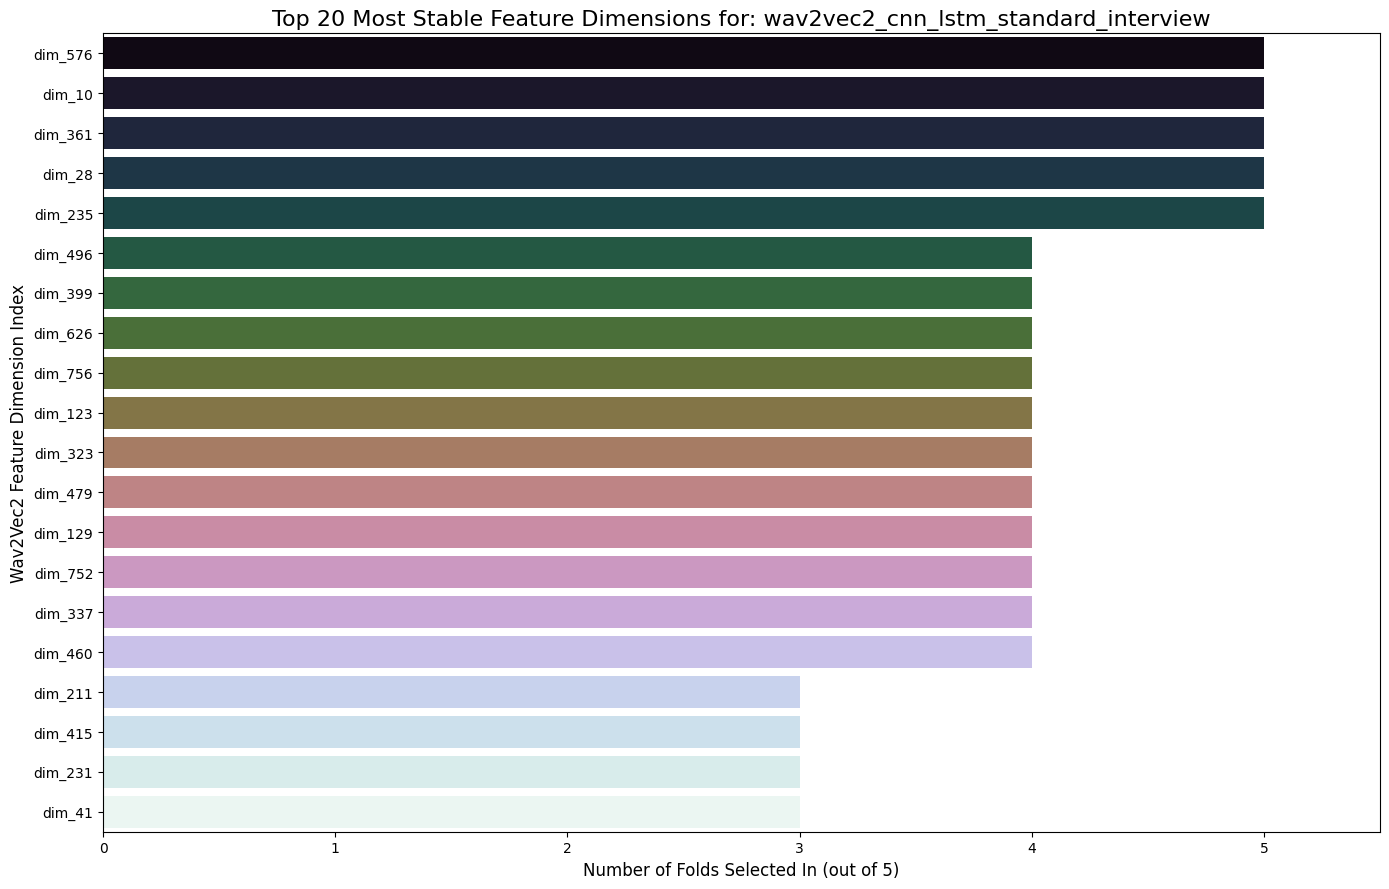

C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\1012311418.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stability_df.head(20), x='count', y='feature_index', palette='cubehelix', orient='h')


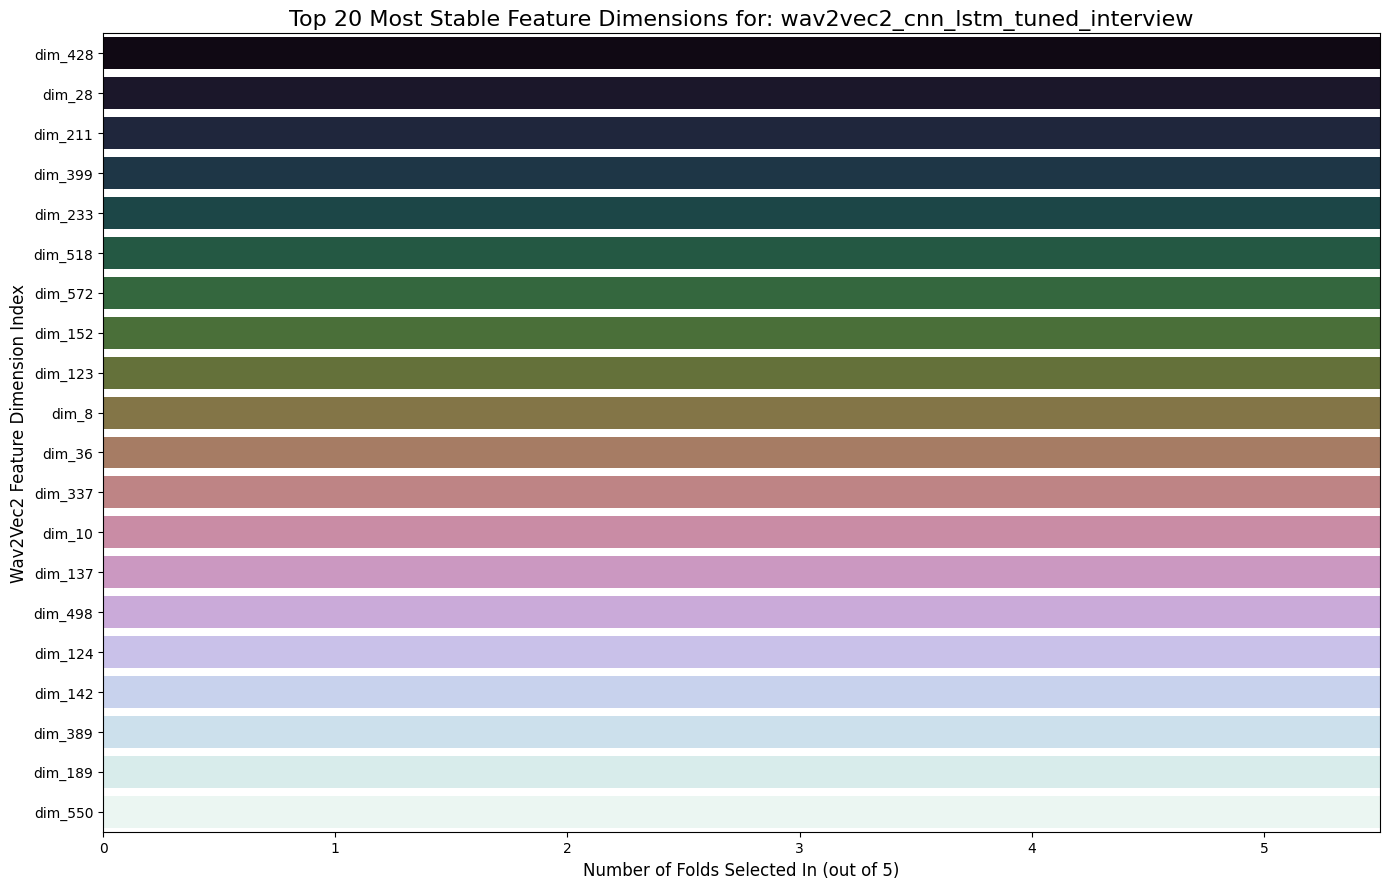

C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\1012311418.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stability_df.head(20), x='count', y='feature_index', palette='cubehelix', orient='h')


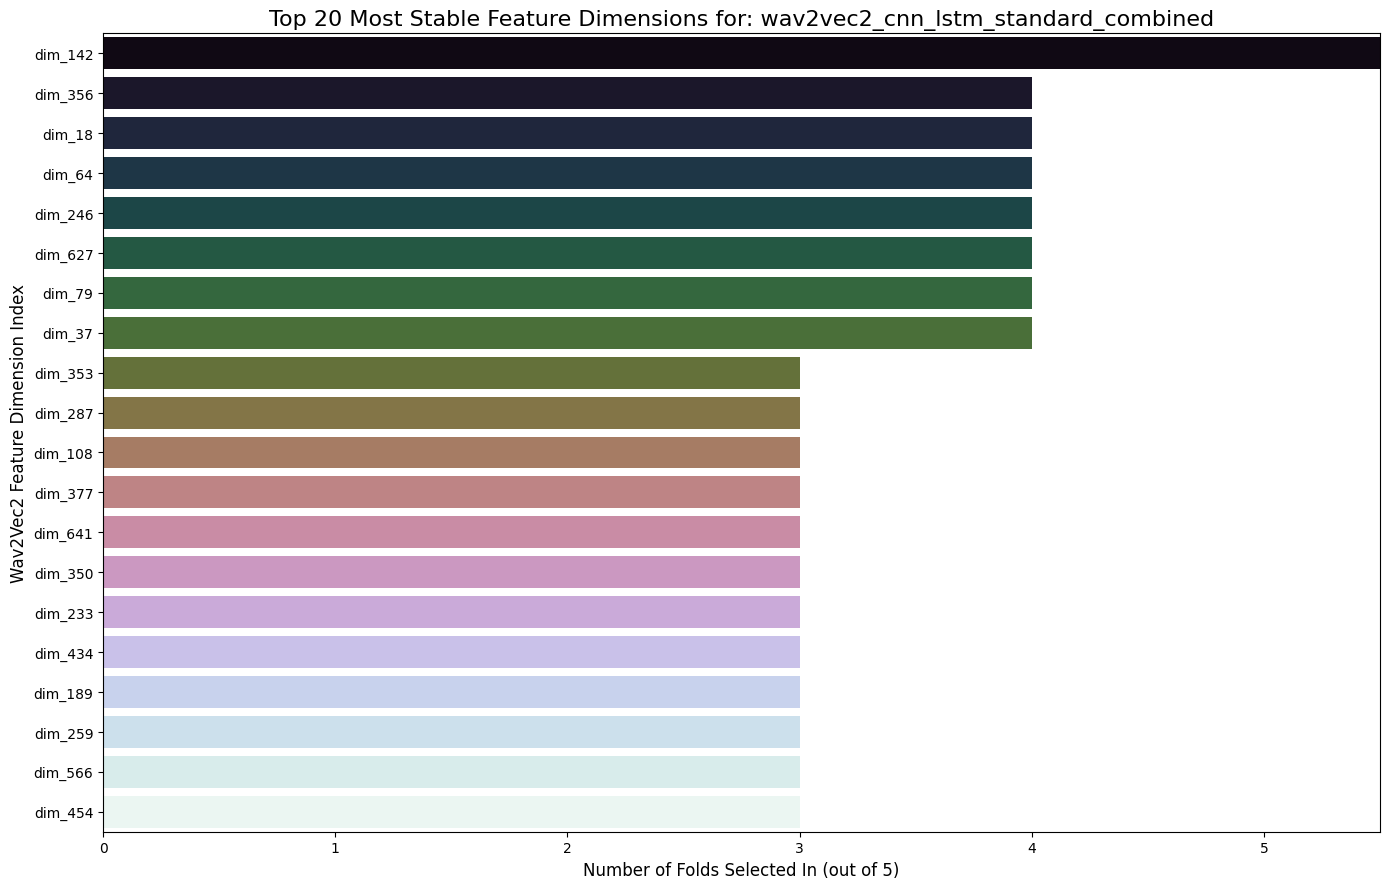

C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\1012311418.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stability_df.head(20), x='count', y='feature_index', palette='cubehelix', orient='h')


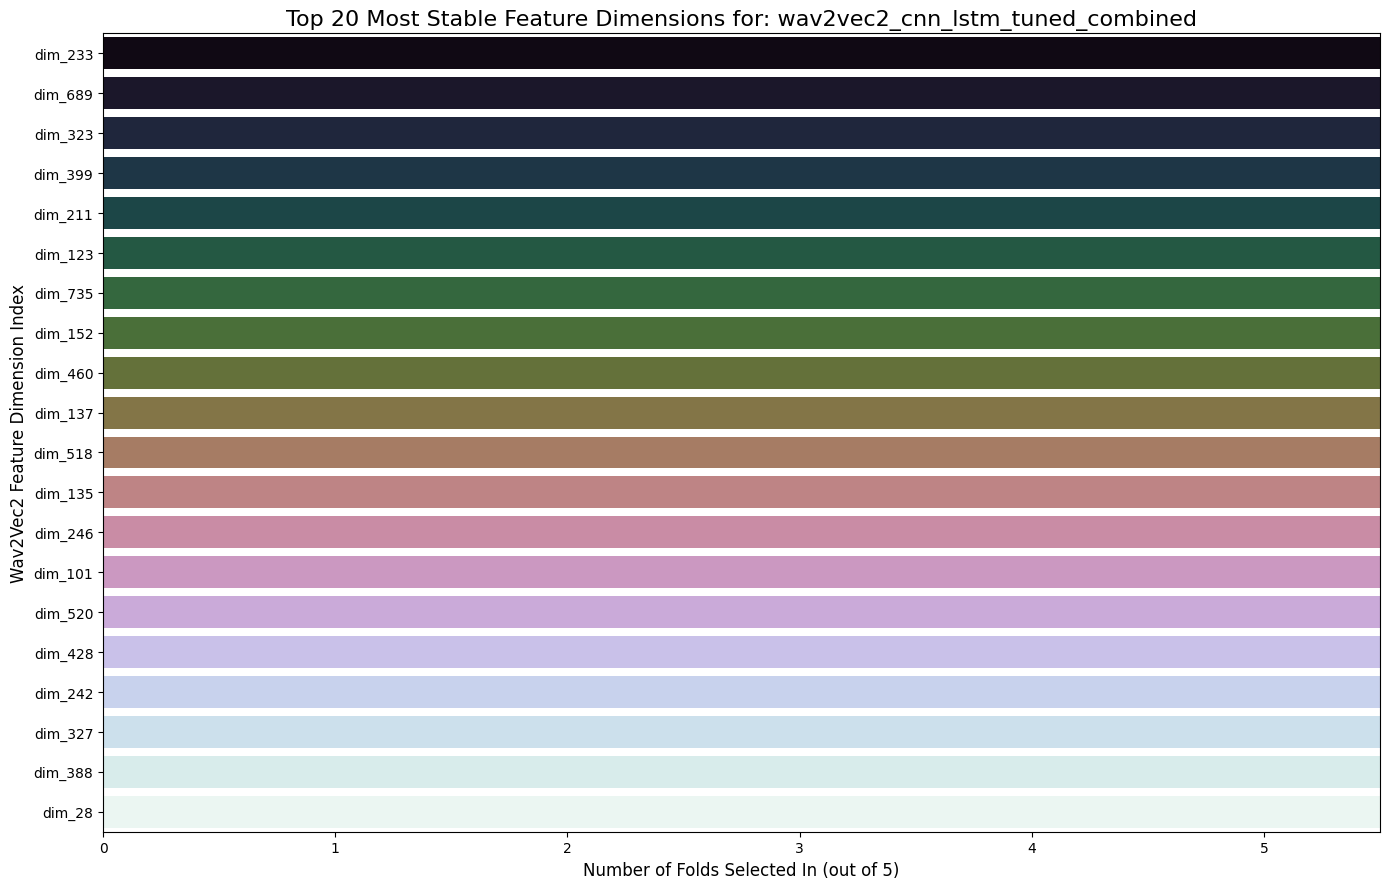

In [11]:
# Visualize Feature Importance Stability for ALL DL Models

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter

print("--- Feature Importance Stability Plots for DL Models ---")

# Loop through each data type AND each CV method
for data_type in ['reading', 'interview', 'combined']:
    for cv_method in ['standard', 'tuned']: # 'tuned' corresponds to the nested CV results
        
        # Construct the full experiment name to look up in our results dictionary
        experiment_name = f'wav2vec2_cnn_lstm_{cv_method}_{data_type}'
        
        # Check if the results for this experiment exist and contain the 'weights' key
        if experiment_name in all_results and 'weights' in all_results[experiment_name]:
            
            # Get the weights (shape: 5 folds x 768 features)
            weights = all_results[experiment_name]['weights']
            
            # Stability Analysis
            # Define "selection" as a feature being in the top N most important for a fold.
            # 50 is a reasonable number for a 768-dimensional space.
            top_n = 50 
            
            # Get the indices of the top N features for each of the 5 folds
            # np.argsort returns the indices that would sort an array.
            # Slicing with [:, -top_n:] gets the indices of the top N largest values.
            top_indices_per_fold = np.argsort(weights, axis=1)[:, -top_n:]
            
            # Count the frequency of each feature index appearing in the top N lists.
            # .flatten() turns the 2D array of indices into a 1D list.
            feature_stability_counts = Counter(top_indices_per_fold.flatten())
            
            if not feature_stability_counts:
                print(f"No stable features found for experiment: {experiment_name}")
                continue
            
            # Create a DataFrame for plotting
            stability_df = pd.DataFrame(feature_stability_counts.items(), columns=['feature_index', 'count'])
            # Convert the raw index (e.g., 106) into a readable name ('dim_106')
            stability_df['feature_index'] = stability_df['feature_index'].apply(lambda x: f'dim_{x}')
            stability_df = stability_df.sort_values(by='count', ascending=False)

            # Visualization
            plt.figure(figsize=(14, 9))
            sns.barplot(data=stability_df.head(20), x='count', y='feature_index', palette='cubehelix', orient='h')
            plt.title(f'Top 20 Most Stable Feature Dimensions for: {experiment_name}', fontsize=16)
            plt.xlabel('Number of Folds Selected In (out of 5)', fontsize=12)
            plt.ylabel('Wav2Vec2 Feature Dimension Index', fontsize=12)
            plt.xlim(0, 5.5)
            plt.tight_layout()
            plt.show()
        
        else:
            print(f"Could not find weights for experiment: {experiment_name}. Skipping plot.")

In [12]:
# Consolidate All SVM and DL Experiment Results 

# Load the SVM results from their single, consolidated file
SVM_RESULTS_PATH = '../data/Processed_Features/all_svm_results.pkl'
if os.path.exists(SVM_RESULTS_PATH):
    print(f"Loading consolidated SVM results from: {SVM_RESULTS_PATH}")
    with open(SVM_RESULTS_PATH, 'rb') as f:
        # Start our master dictionary with all the SVM results
        all_results = pickle.load(f)
else:
    print("Warning: SVM results file not found. Final comparison will only show DL models.")
    all_results = {}

# Load the individual DL results and add them to the master dictionary
# Define the names of the 6 individual DL experiment result files
dl_experiment_names = [
    'wav2vec2_cnn_lstm_standard_reading',
    'wav2vec2_cnn_lstm_tuned_reading',
    'wav2vec2_cnn_lstm_standard_interview',
    'wav2vec2_cnn_lstm_tuned_interview',
    'wav2vec2_cnn_lstm_standard_combined',
    'wav2vec2_cnn_lstm_tuned_combined'
]

# Loop through names, load the corresponding .pkl file for each DL experiment
for name in dl_experiment_names:
    path = f'../data/Processed_Features/results_{name}.pkl'
    if os.path.exists(path):
        with open(path, 'rb') as f:
            # Add the loaded DL result to the master dictionary
            all_results[name] = pickle.load(f)
    else:
        print(f"Warning: Could not find results file for DL experiment: {name}")

print(f"\nSuccessfully loaded a total of {len(all_results)} experiment results for final comparison.")

# Create and Display the final, comprehensive summary DataFrame
final_summary_data = []
for experiment_name, data in all_results.items():
    results_df = data['results_df']
    final_summary_data.append({
        'Experiment': experiment_name,
        'Mean F1-Score': results_df['f1_score'].mean(),
        'Std Dev F1-Score': results_df['f1_score'].std(),
        'Mean AUC': results_df['auc'].mean(),
        'Std Dev AUC': results_df['auc'].std(),
    })

final_summary_df = pd.DataFrame(final_summary_data).set_index('Experiment')

print("\n--- Final Comprehensive Results Summary Table. ---")
display(final_summary_df.style.background_gradient(cmap='viridis', subset=[c for c in final_summary_df.columns if 'Mean' in c], axis=0)
                          .background_gradient(cmap='viridis_r', subset=[c for c in final_summary_df.columns if 'Std Dev' in c], axis=0)
                          .format("{:.3f}"))

Loading consolidated SVM results from: ../data/Processed_Features/all_svm_results.pkl

Successfully loaded a total of 24 experiment results for final comparison.

--- Final Comprehensive Results Summary Table. ---


,Mean F1-Score,Std Dev F1-Score,Mean AUC,Std Dev AUC
Experiment,,,,
mshds_reading_standard,0.735,0.081,0.810,0.068
mshds_reading_nested,0.706,0.176,0.764,0.181
opensmile_reading_standard,0.586,0.104,0.572,0.096
opensmile_reading_nested,0.563,0.094,0.565,0.105
wav2vec2_reading_standard,0.664,0.071,0.703,0.096
wav2vec2_reading_nested,0.654,0.036,0.766,0.090
mshds_interview_standard,0.718,0.101,0.769,0.141
mshds_interview_nested,0.709,0.094,0.766,0.121
opensmile_interview_standard,0.685,0.040,0.738,0.040


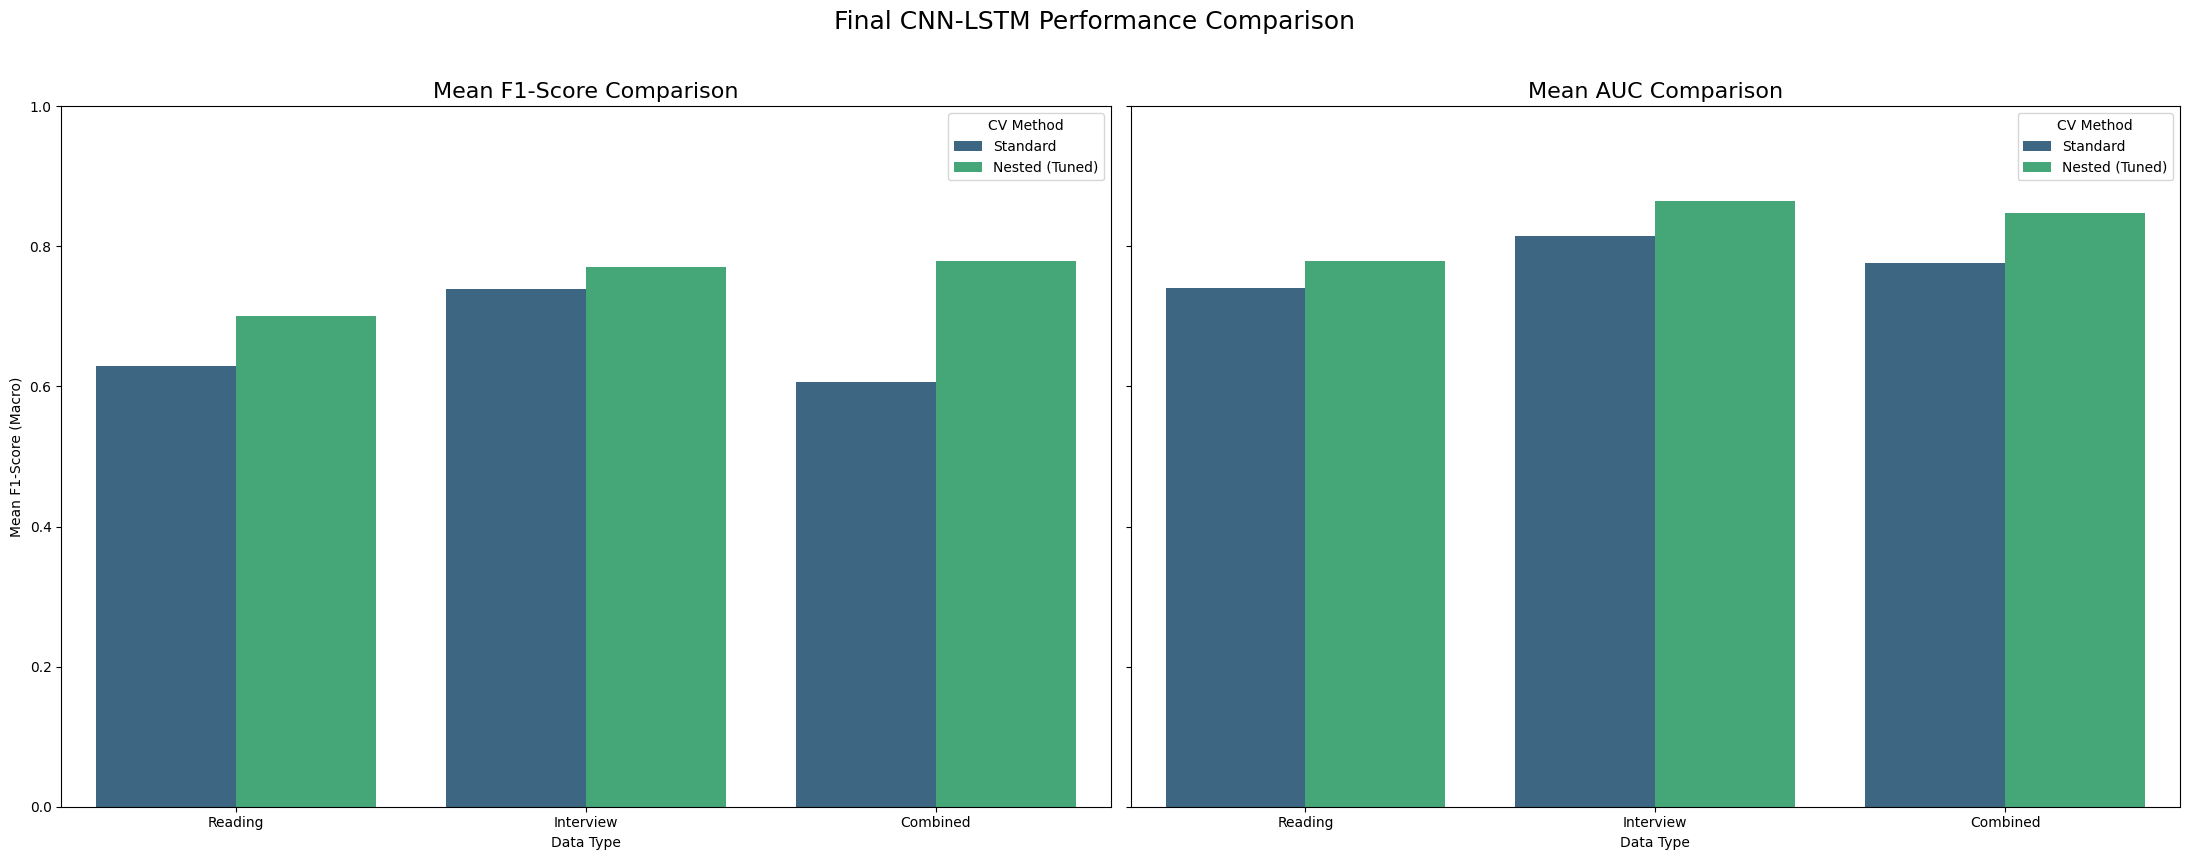

In [13]:
# Final CNN-LSTM Performance Comparison

# Filter the master summary_df to get only the CNN-LSTM results.
dl_summary_df = final_summary_df[final_summary_df.index.str.contains('cnn_lstm')].copy()

# Create clean columns for plotting
dl_summary_df['Data Type'] = [
    'Reading' if 'reading' in idx else 'Interview' if 'interview' in idx else 'Combined' 
    for idx in dl_summary_df.index
]
# Correctly label the tuned/nested method
dl_summary_df['CV Method'] = ['Standard' if 'standard' in idx else 'Nested (Tuned)' for idx in dl_summary_df.index]

# Create the figure with two side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 9), sharey=True)
fig.suptitle('Final CNN-LSTM Performance Comparison', fontsize=18)

# Plot for F1-Score
sns.barplot(ax=axes[0], data=dl_summary_df, x='Data Type', y='Mean F1-Score', hue='CV Method', 
            palette='viridis', order=['Reading', 'Interview', 'Combined'])
axes[0].set_title('Mean F1-Score Comparison', fontsize=16)
axes[0].set_ylabel('Mean F1-Score (Macro)'); axes[0].set_xlabel('Data Type'); axes[0].set_ylim(0, 1.0)
axes[0].legend(title='CV Method')

# Plot for AUC
sns.barplot(ax=axes[1], data=dl_summary_df, x='Data Type', y='Mean AUC', hue='CV Method', 
            palette='viridis', order=['Reading', 'Interview', 'Combined'])
axes[1].set_title('Mean AUC Comparison', fontsize=16)
axes[1].set_ylabel('Mean AUC'); axes[1].set_xlabel('Data Type')
axes[1].legend(title='CV Method')

plt.tight_layout(rect=[0, 0.03, 1, 0.96]); plt.show()

C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\1764334437.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=f1_pivot.index, y=f1_pivot['performance_gain'], palette='coolwarm', order=['Reading', 'Interview', 'Combined'])
C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\1764334437.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=auc_pivot.index, y=auc_pivot['performance_gain'], palette='coolwarm', order=['Reading', 'Interview', 'Combined'])


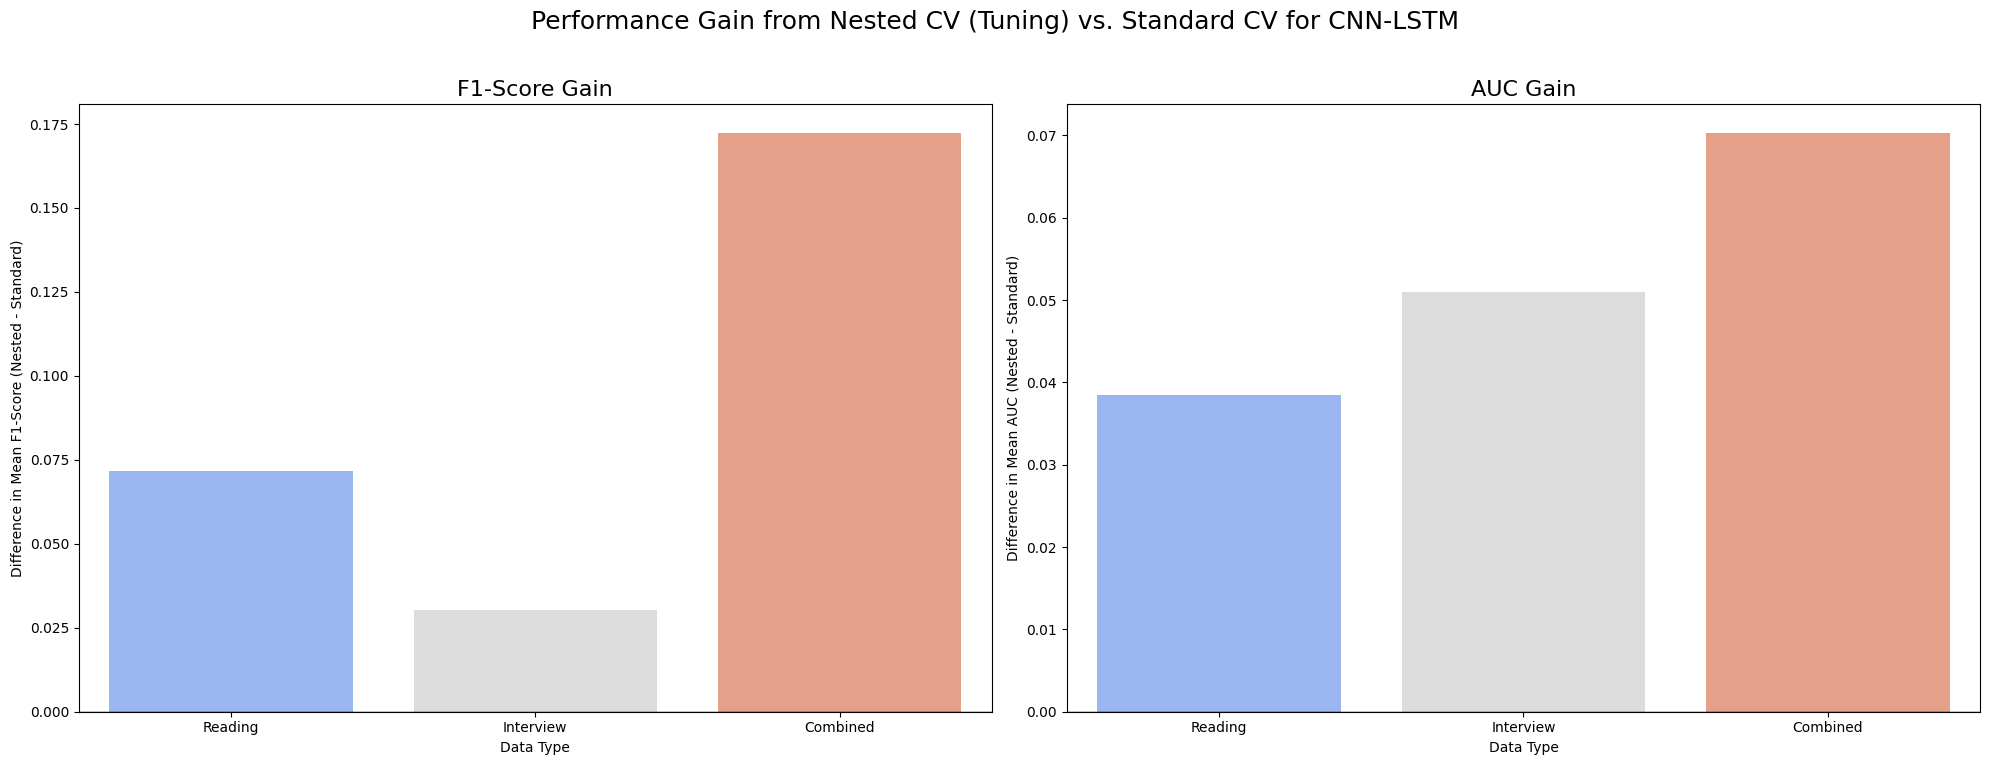

In [14]:
# Performance Gain from Robust Tuning (Nested - Standard) for CNN-LSTM

# The 'dl_summary_df' DataFrame was created in the cell above.
pivot_df = dl_summary_df.copy()
pivot_df['data_type'] = ['Reading' if 'reading' in idx else 'Interview' if 'interview' in idx else 'Combined' for idx in pivot_df.index]
pivot_df['cv_method'] = ['standard' if 'standard' in idx else 'nested' for idx in pivot_df.index]

# Pivot for F1-Score and calculate the gain
f1_pivot = pivot_df.pivot_table(index='data_type', columns='cv_method', values='Mean F1-Score')
f1_pivot['performance_gain'] = f1_pivot['nested'] - f1_pivot['standard']

# Pivot for AUC and calculate the gain
auc_pivot = pivot_df.pivot_table(index='data_type', columns='cv_method', values='Mean AUC')
auc_pivot['performance_gain'] = auc_pivot['nested'] - auc_pivot['standard']

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Performance Gain from Nested CV (Tuning) vs. Standard CV for CNN-LSTM', fontsize=18)

sns.barplot(ax=axes[0], x=f1_pivot.index, y=f1_pivot['performance_gain'], palette='coolwarm', order=['Reading', 'Interview', 'Combined'])
axes[0].set_title('F1-Score Gain', fontsize=16); axes[0].set_ylabel('Difference in Mean F1-Score (Nested - Standard)'); axes[0].set_xlabel('Data Type'); axes[0].axhline(0, color='black', lw=1.0)

sns.barplot(ax=axes[1], x=auc_pivot.index, y=auc_pivot['performance_gain'], palette='coolwarm', order=['Reading', 'Interview', 'Combined'])
axes[1].set_title('AUC Gain', fontsize=16); axes[1].set_ylabel('Difference in Mean AUC (Nested - Standard)'); axes[1].set_xlabel('Data Type'); axes[1].axhline(0, color='black', lw=1.0)

plt.tight_layout(rect=[0, 0.03, 1, 0.96]); plt.show()

C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\450382969.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=f1_pivot.index, y=f1_pivot['performance_gain'], hue_order=['Standard', 'Nested (Tuned)'], palette='plasma')
C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\450382969.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=auc_pivot.index, y=auc_pivot['performance_gain'], palette='plasma')


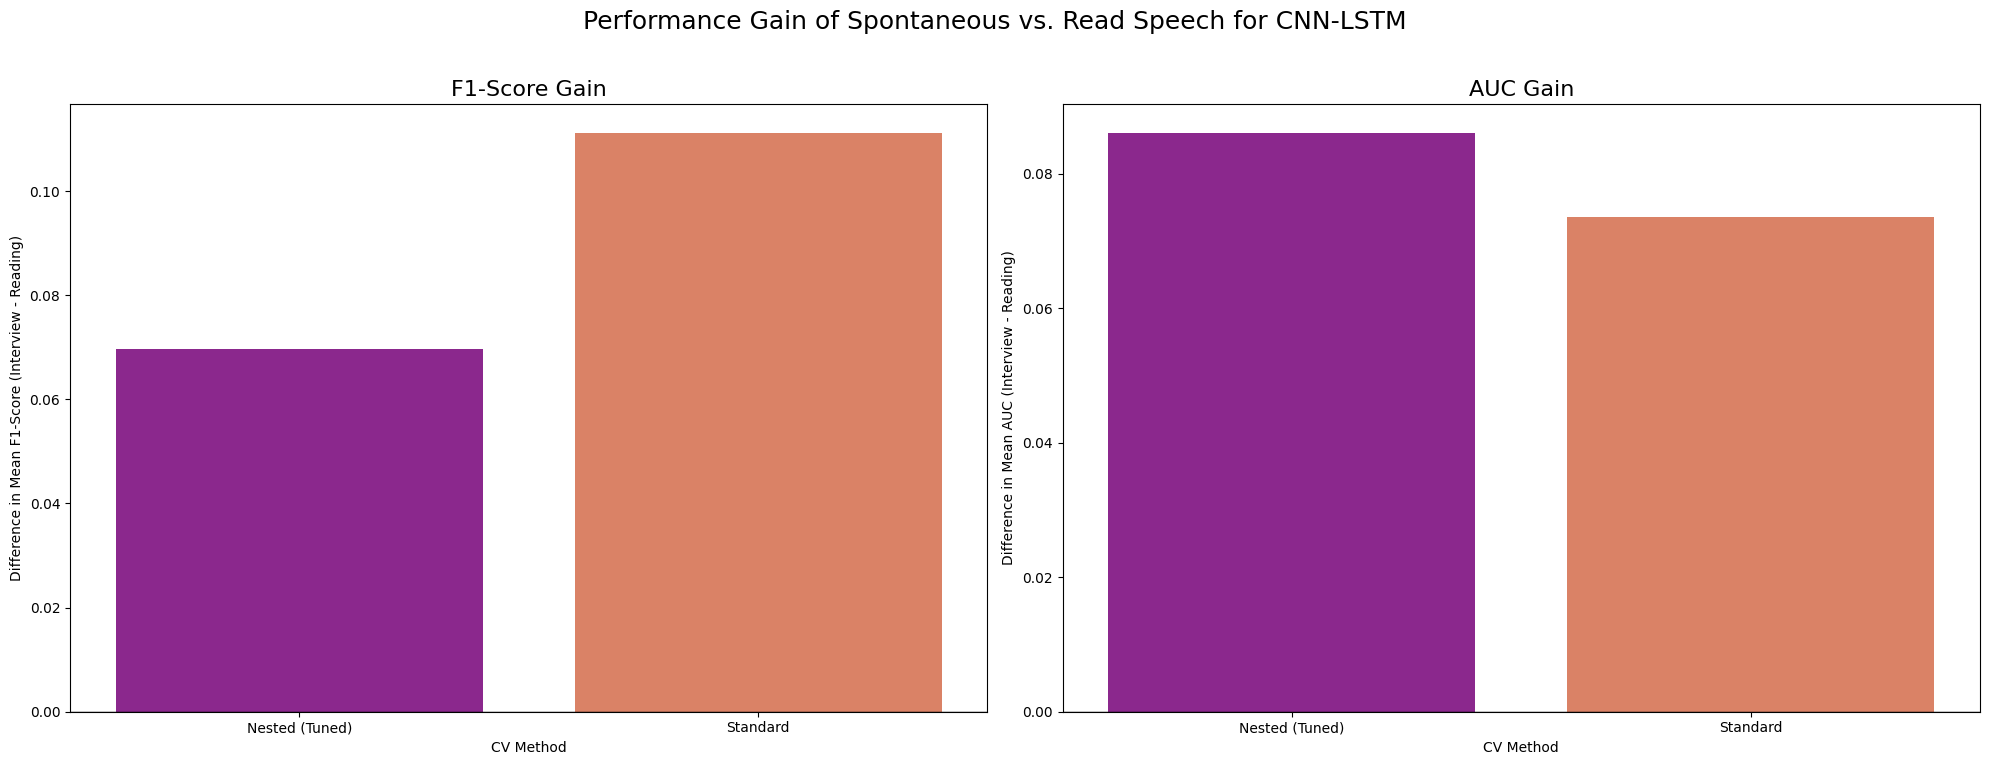

In [15]:
# Performance Gain of Spontaneous vs. Read Speech for CNN-LSTM

# Filter the DL summary DataFrame to exclude 'combined' results
# 'dl_summary_df' DataFrame exists from previous cells
task_comparison_df = dl_summary_df[~dl_summary_df['Data Type'].isin(['Combined'])].copy()

# Create the Figure and Subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Performance Gain of Spontaneous vs. Read Speech for CNN-LSTM', fontsize=18)

# Plot for F1-Score
# Pivot the data to get Reading and Interview scores on the same row for each CV method
f1_pivot = task_comparison_df.pivot_table(index='CV Method', columns='Data Type', values='Mean F1-Score')
# Calculate the performance gain
f1_pivot['performance_gain'] = f1_pivot['Interview'] - f1_pivot['Reading']

# Create the bar plot on the first axis
sns.barplot(ax=axes[0], x=f1_pivot.index, y=f1_pivot['performance_gain'], hue_order=['Standard', 'Nested (Tuned)'], palette='plasma')
axes[0].set_title('F1-Score Gain', fontsize=16)
axes[0].set_ylabel('Difference in Mean F1-Score (Interview - Reading)')
axes[0].set_xlabel('CV Method')
axes[0].axhline(0, color='black', lw=1.0)

# Plot for AUC
# Pivot the data for AUC scores
auc_pivot = task_comparison_df.pivot_table(index='CV Method', columns='Data Type', values='Mean AUC')
# Calculate the performance gain for AUC
auc_pivot['performance_gain'] = auc_pivot['Interview'] - auc_pivot['Reading']

# Create the bar plot on the second axis
sns.barplot(ax=axes[1], x=auc_pivot.index, y=auc_pivot['performance_gain'], palette='plasma')
axes[1].set_title('AUC Gain', fontsize=16)
axes[1].set_ylabel('Difference in Mean AUC (Interview - Reading)')
axes[1].set_xlabel('CV Method')
axes[1].axhline(0, color='black', lw=1.0)

# Show Plot
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

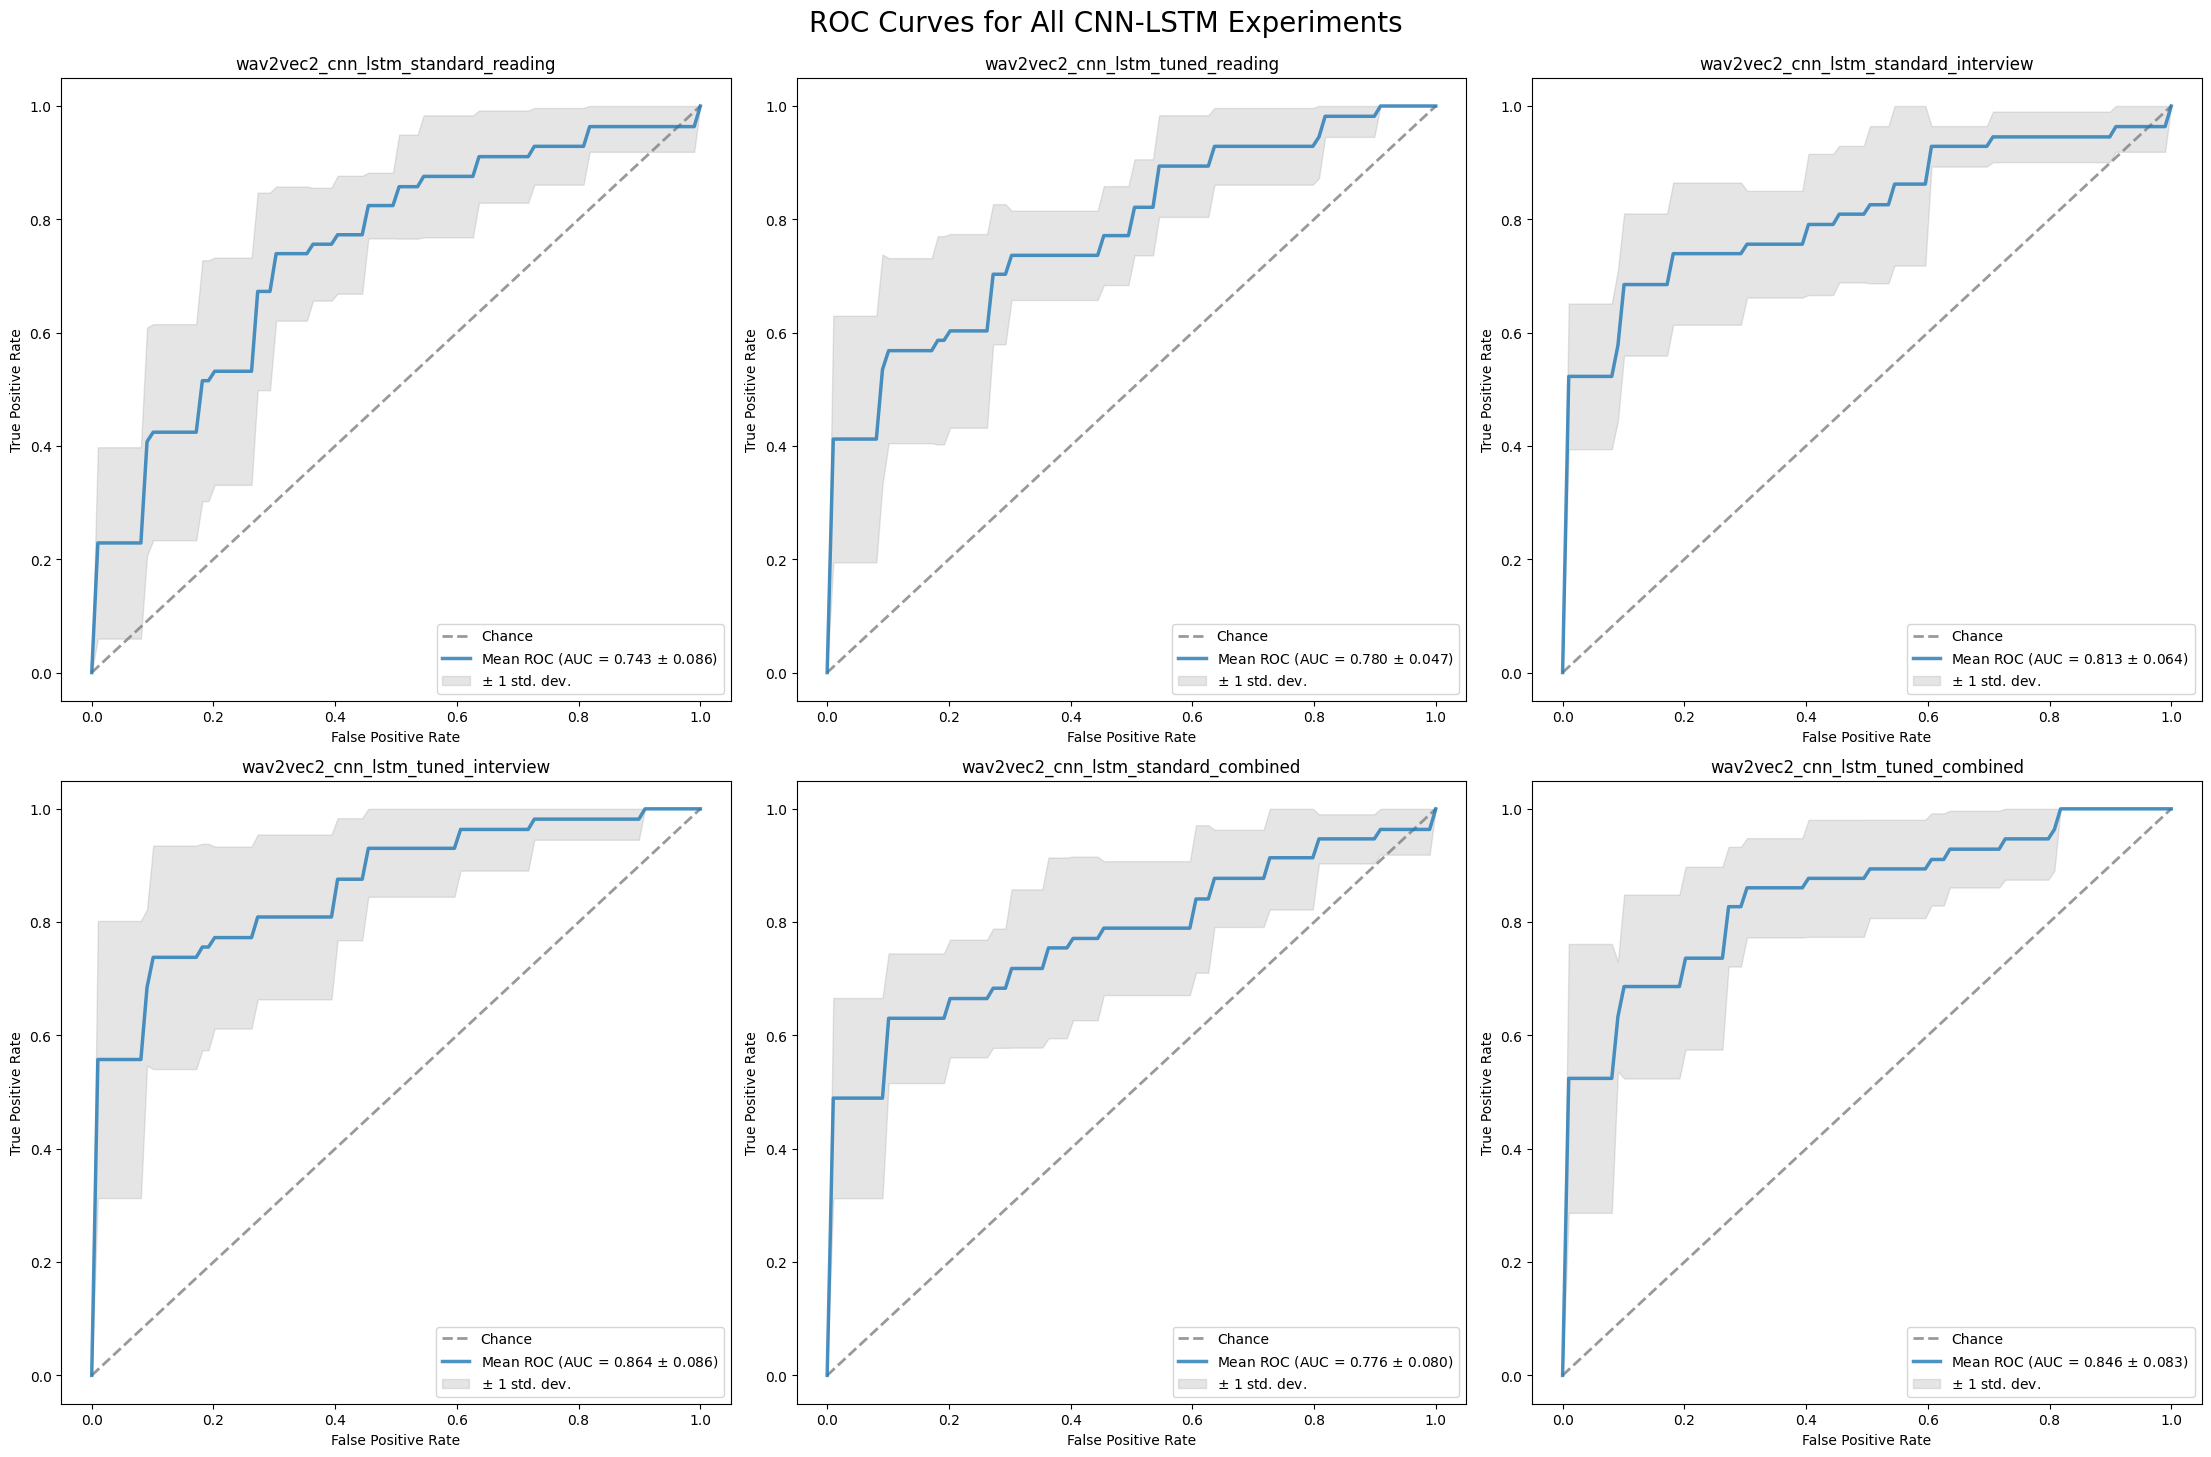

In [16]:
# ROC Curves for All Deep Learning Experiments

from sklearn.metrics import roc_curve, auc

# Filter the master results dictionary to get only the DL experiments
dl_results_only = {k: v for k, v in all_results.items() if 'cnn_lstm' in k}

# Create a 2x3 grid of subplots for the 6 DL experiments
fig, axes = plt.subplots(2, 3, figsize=(22, 14), constrained_layout=True)
axes = axes.ravel() # Flatten the 2x3 grid

fig.suptitle('ROC Curves for All CNN-LSTM Experiments', fontsize=20, y=1.03)

# Enumerate through the filtered experiments to plot them
for i, (experiment_name, data) in enumerate(dl_results_only.items()):
    ax = axes[i]
    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    
    # Plot the ROC curve for each of the 5 folds
    for fold_data in data['predictions']:
        fpr, tpr, _ = roc_curve(fold_data['y_true'], fold_data['y_prob'])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))
    
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey', label='Chance', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0); mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='C0', label=f'Mean ROC (AUC = {mean_auc:.3f} $\pm$ {std_auc:.3f})', lw=2.5, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title=f"{experiment_name}",
           xlabel="False Positive Rate",
           ylabel="True Positive Rate")
    ax.legend(loc="lower right")

# Turn off any subplots that are not used
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.show()

C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\2085278043.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=plot_df, x='cv_method', y=metric, palette=cv_palette)
C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\2085278043.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=plot_df, x='cv_method', y=metric, palette=cv_palette)
C:\Users\ayush\AppData\Local\Temp\ipykernel_13196\2085278043.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, data=plot_df, x='cv_method', y=metric, palette=cv_palette)
C:\User

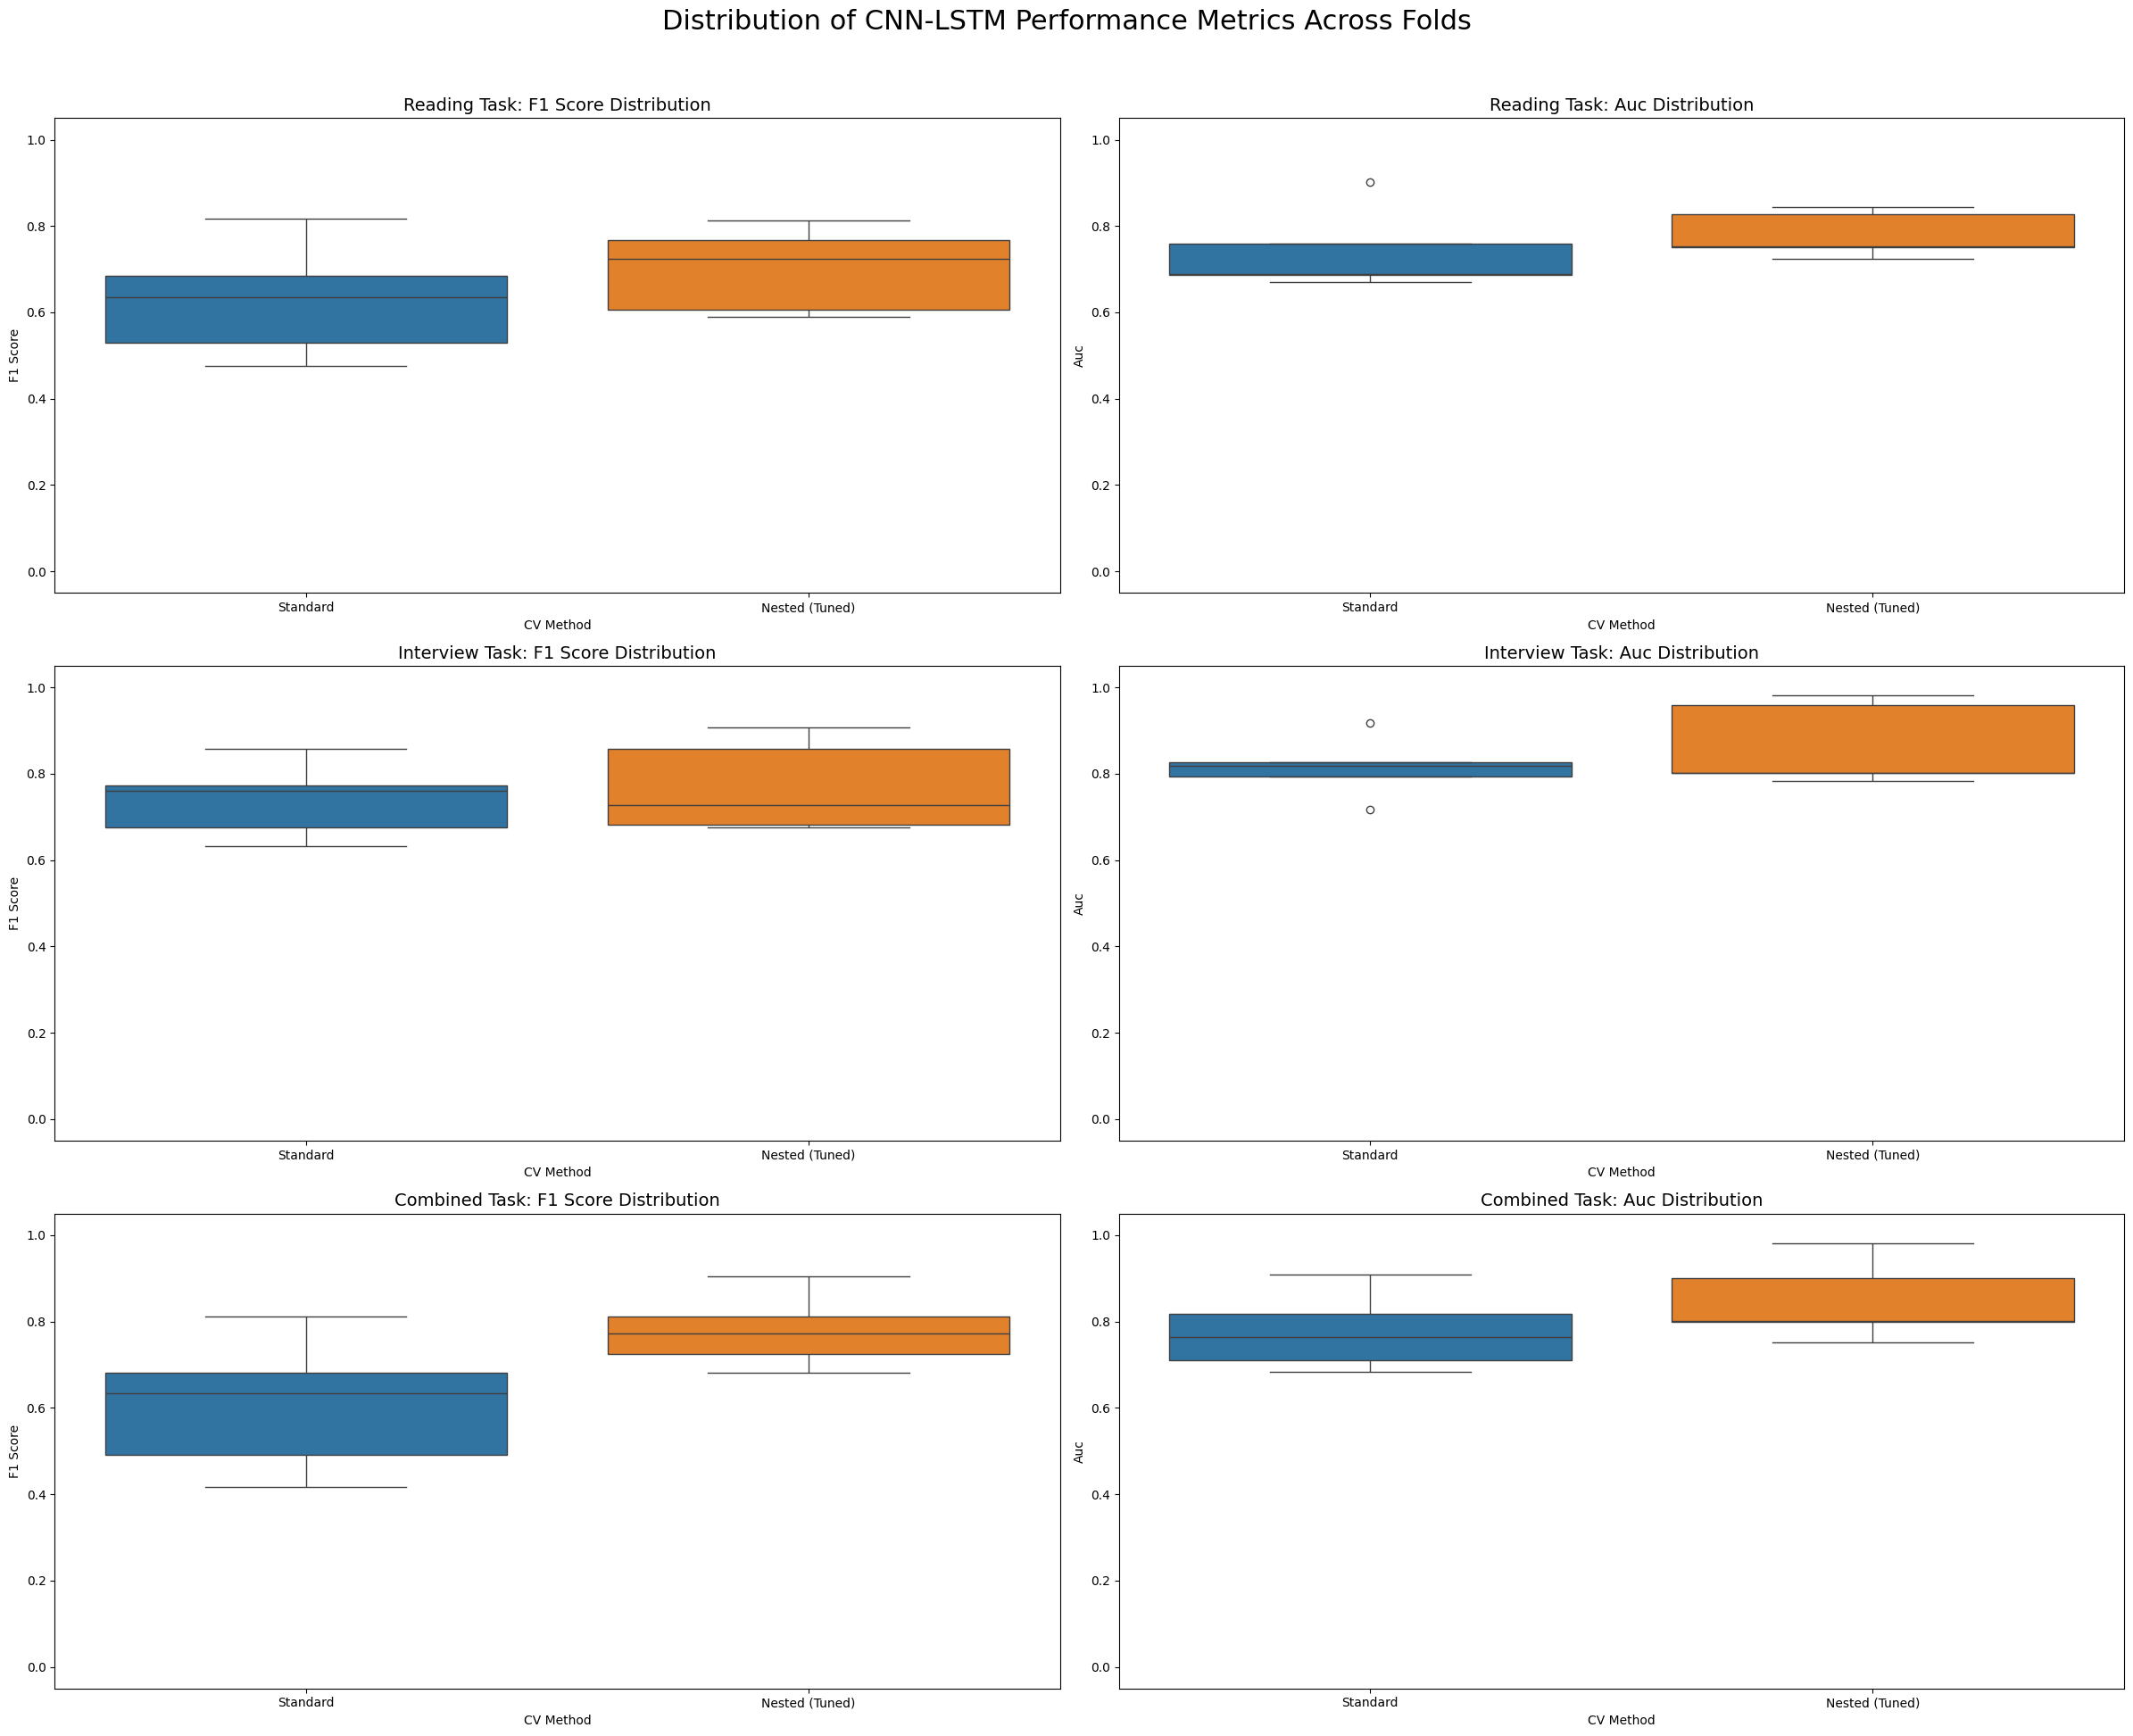

In [17]:
# Distribution of DL Performance Metrics

# Prepare a "long-form" DataFrame for the DL results
dl_fold_results = []
dl_experiment_names = [exp for exp in all_results.keys() if 'cnn_lstm' in exp]

for name in dl_experiment_names:
    df = all_results[name]['results_df'].copy()
    df['experiment'] = name
    dl_fold_results.append(df)

dl_long_form_df = pd.concat(dl_fold_results, ignore_index=True)

# Columns for hue (CV method) and faceting (data type)
dl_long_form_df['data_type'] = [
    'Reading' if 'reading' in name else 'Interview' if 'interview' in name else 'Combined'
    for name in dl_long_form_df['experiment']
]
dl_long_form_df['cv_method'] = ['Standard' if 'standard' in name else 'Nested (Tuned)' for name in dl_long_form_df['experiment']]

# 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(24, 20), sharey=False)
fig.suptitle('Distribution of CNN-LSTM Performance Metrics Across Folds', fontsize=22, y=1.0)

data_types = ['Reading', 'Interview', 'Combined']
metrics_to_plot = ['f1_score', 'auc']
cv_palette = {"Standard": "C0", "Nested (Tuned)": "C1"}

# Create plots
for row_idx, data_type in enumerate(data_types):
    for col_idx, metric in enumerate(metrics_to_plot):
        ax = axes[row_idx, col_idx]
        plot_df = dl_long_form_df[dl_long_form_df['data_type'] == data_type]
        
        sns.boxplot(ax=ax, data=plot_df, x='cv_method', y=metric, palette=cv_palette)
        
        metric_name = metric.replace('_', ' ').title()
        ax.set_title(f'{data_type} Task: {metric_name} Distribution', fontsize=14)
        ax.set_ylabel(metric_name)
        ax.set_xlabel("CV Method")
        ax.set_ylim(-0.05, 1.05)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

Setting consistent axis limits: Y-axis (0.51, 0.83), X-axis (0.02, 0.19)


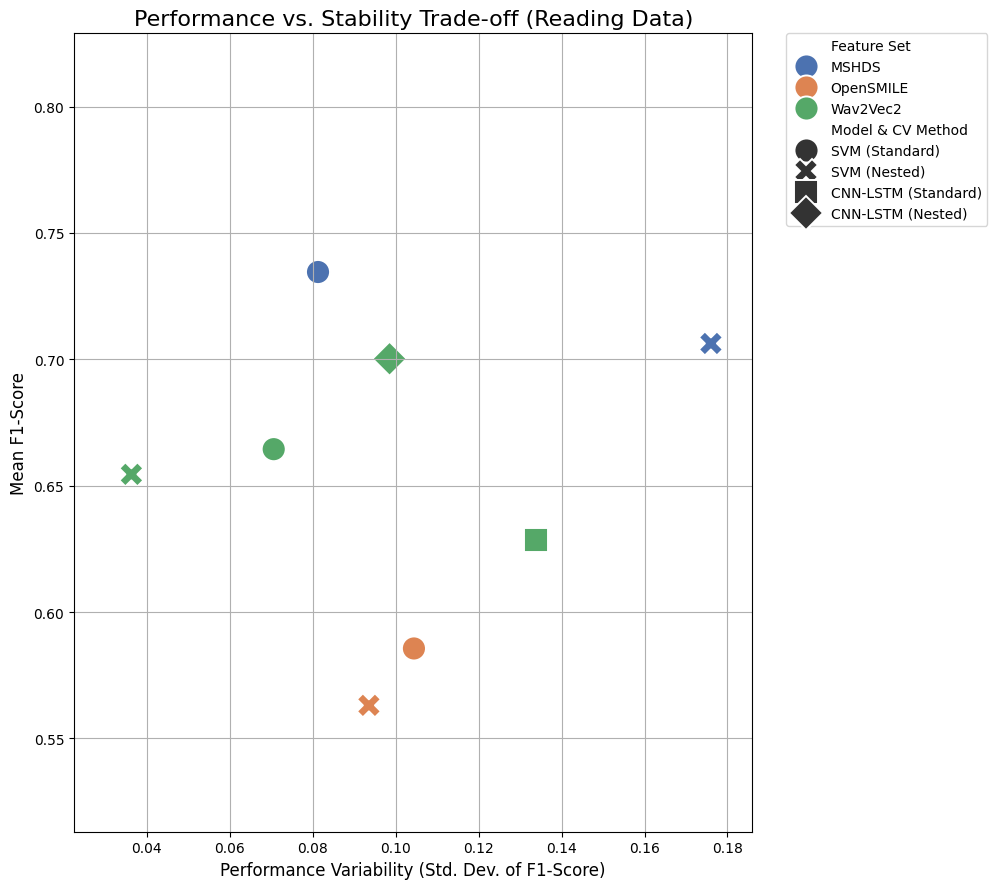

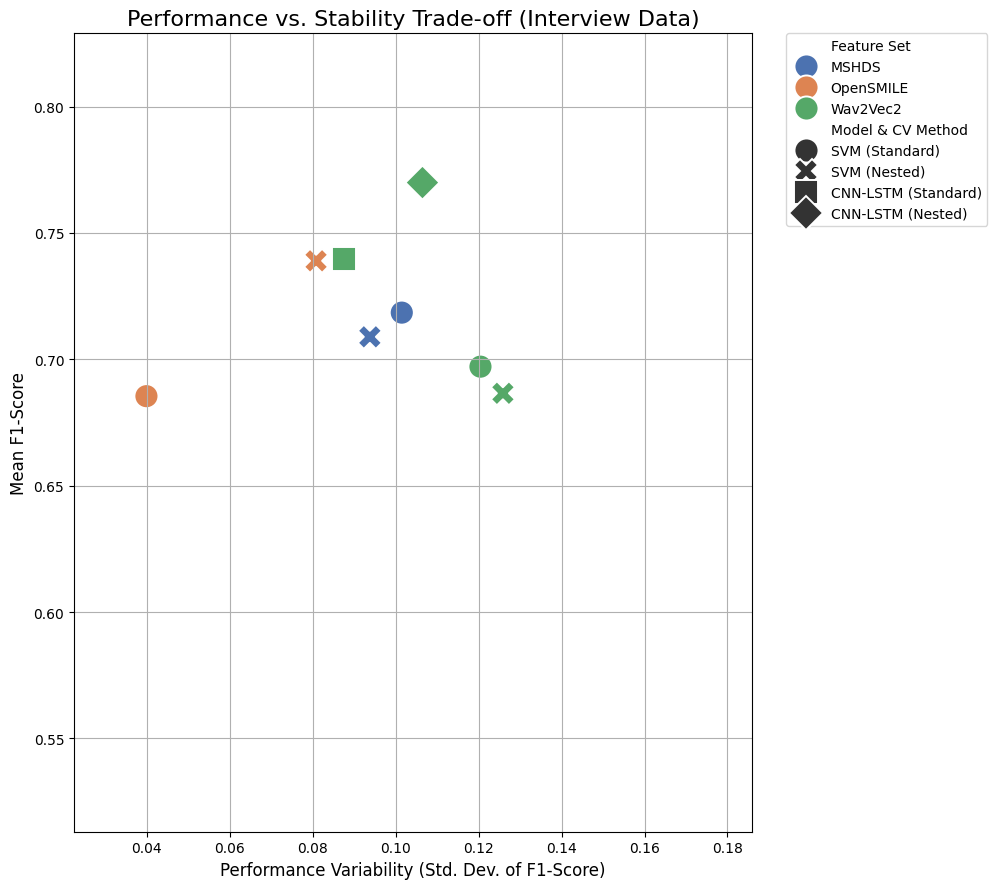

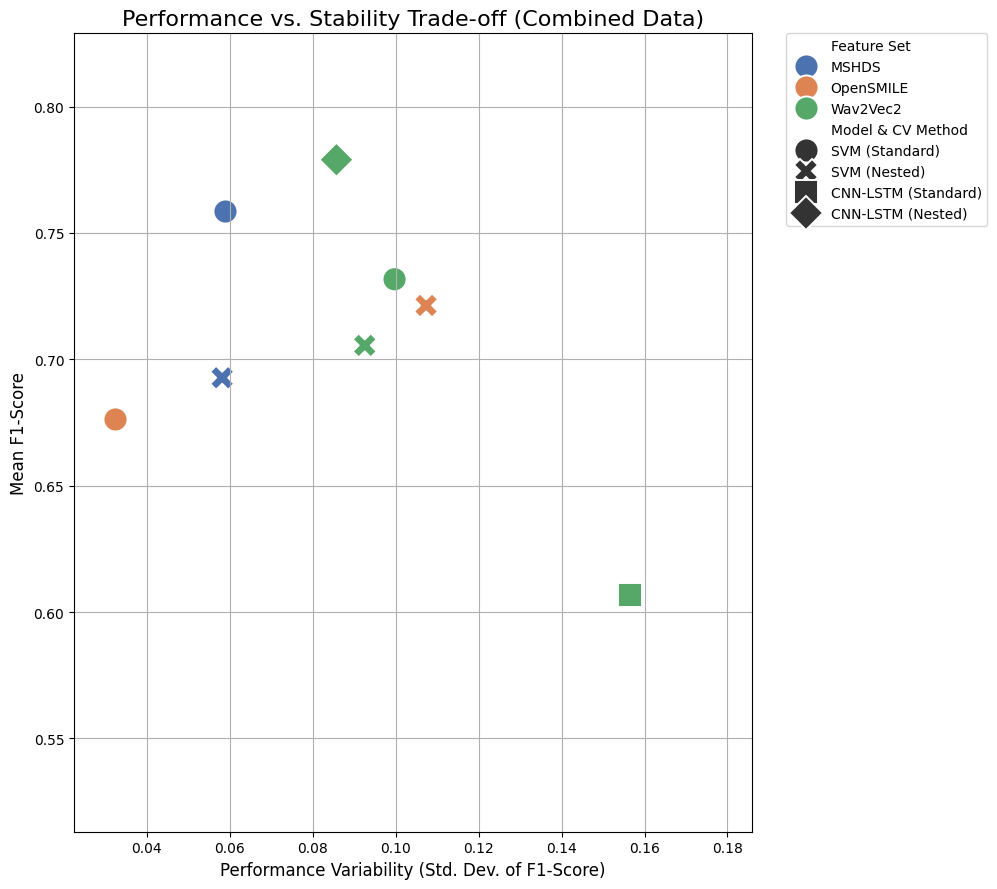

In [18]:
# Performance vs. Stability Plots for all experiments grouped by data types

# Prepare the Data for Plotting 
# The 'final_summary_df' DataFrame should exist from a previous cell.
tradeoff_df = final_summary_df.copy().reset_index()

# Create the categorical columns needed for plotting
tradeoff_df['CV Method'] = ['Standard' if 'standard' in n else 'Nested' for n in tradeoff_df['Experiment']]
tradeoff_df['Model'] = ['SVM' if 'cnn_lstm' not in n else 'CNN-LSTM' for n in tradeoff_df['Experiment']]
tradeoff_df['Feature Set'] = [
    'MSHDS' if 'mshds' in n else 'OpenSMILE' if 'opensmile' in n else 'Wav2Vec2'
    for n in tradeoff_df['Experiment']
]
tradeoff_df['Data Type'] = [
    'Reading' if 'reading' in n else 'Interview' if 'interview' in n else 'Combined'
    for n in tradeoff_df['Experiment']
]
tradeoff_df['Model & CV Method'] = tradeoff_df['Model'] + ' (' + tradeoff_df['CV Method'] + ')'

# Determine Global Axis Limits before Plotting, to enable relative comparisons across plots
# Find the overall min/max for the y-axis (performance) across all experiments
y_min = tradeoff_df['Mean F1-Score'].min() - 0.05
y_max = tradeoff_df['Mean F1-Score'].max() + 0.05

# Find the overall min/max for the x-axis (variability) across all experiments
x_min = tradeoff_df['Std Dev F1-Score'].min() - 0.01
x_max = tradeoff_df['Std Dev F1-Score'].max() + 0.01

print(f"Setting consistent axis limits: Y-axis ({y_min:.2f}, {y_max:.2f}), X-axis ({x_min:.2f}, {x_max:.2f})")


# Create a Separate Plot for Each Data Type

# Define the unique markers for clarity
markers = {
    "SVM (Standard)": "o", 
    "SVM (Nested)": "X", 
    "CNN-LSTM (Standard)": "s", 
    "CNN-LSTM (Nested)": "D"
}

# Loop through each data type
for data_type in ['Reading', 'Interview', 'Combined']:
    
    plt.figure(figsize=(12, 9))
    ax = plt.gca()
    
    plot_data = tradeoff_df[tradeoff_df['Data Type'] == data_type]
    
    sns.scatterplot(
        ax=ax,
        data=plot_data,
        x='Std Dev F1-Score',
        y='Mean F1-Score',
        hue='Feature Set',
        style='Model & CV Method',
        s=300,
        palette='deep',
        markers=markers
    )
    
    # Apply the global axis limits to each plot
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Finalize and show plot
    plt.title(f'Performance vs. Stability Trade-off ({data_type} Data)', fontsize=16)
    plt.xlabel('Performance Variability (Std. Dev. of F1-Score)', fontsize=12)
    plt.ylabel('Mean F1-Score', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

In [ ]:
# Extract the 'best_params' from each fold of each experiment
all_best_params = []
for experiment_name, data in tuned_dl_results.items(): # tuned_dl_results is the dictionary containing results from the nested CV runs earlier
    results_df = data['results_df']
    # 'best_params' is a column of dictionaries, need to expand it
    params_df = pd.json_normalize(results_df['best_params'])
    params_df['experiment'] = experiment_name
    all_best_params.append(params_df)

# Concatenate into a single DataFrame
hyperparams_df = pd.concat(all_best_params, ignore_index=True)

# Create a clean data_type column for grouping
hyperparams_df['data_type'] = [
    'Reading' if 'reading' in n else 'Interview' if 'interview' in n else 'Combined'
    for n in hyperparams_df['experiment']
]

# Create a Summary Table
# For numeric parameters, calculate the mean. For categorical, find the most common value (mode).
hyperparam_summary = hyperparams_df.groupby('data_type').agg({
    'learning_rate': 'mean',
    'dropout_rate': 'mean',
    'cnn_out_channels': lambda x: x.mode()[0], # Gets the most frequent value
    'lstm_hidden_dim': lambda x: x.mode()[0],
    'activation_fn': lambda x: x.mode()[0]
}).reset_index()

# Format the table for display
hyperparam_summary['learning_rate'] = hyperparam_summary['learning_rate'].map('{:.2e}'.format)
hyperparam_summary['dropout_rate'] = hyperparam_summary['dropout_rate'].round(3)

print("--- Summary of Best Hyperparameters Found by Optuna ---")
display(hyperparam_summary.rename(columns={'data_type': 'Data Type'}))

--- Summary of Best Hyperparameters Found by Optuna ---


,Data Type,learning_rate,dropout_rate,cnn_out_channels,lstm_hidden_dim,activation_fn
0,Combined,3.21e-04,0.312,64,128,silu
1,Interview,4.36e-04,0.371,32,128,silu
2,Reading,1.09e-04,0.382,128,64,silu
